# Capstone Project (Group 8) - Maverik

### Meghana Nerusu


# Table of Contents

> [1.Business Problem Statement](#BPS) 

> [2.Import packages and Load data](#IPL)

> [3. Time Series Data](#TSD)    
   >> [3.1 Overview](#O)   
   >> [3.2 Exploring the dataset](#ED)   
   
> [4. Qualitative Data](#QD)
   >> [4.1 Overview](#OQ)   
   >> [4.2 Exploring the dataset](#EDQ)     

> [5. Merged Data](#MD)     
   >> [5.1 Overview](#OM)    
   >> [5.2 Exploring the Dataset](#EDM)     
   >> [5.3 Label Encoding](#LM)      
   
> [6. Modelling Preparation](#MP)
  >>  [6.1 Time Feature Extraction](#TFE)        
  >>  [6.2 Label Encoding](#LE)    
  >>  [6.3  ACF & PCAF for each target variable](#AP)        
  >>  [6.4 Stationarity Test](#ST)
  
> [7. Modelling](#M)
  >>   [7.1 Prophet Model](#PM)         
  >>   [7.2 Exponential Triple Smoothing](#ETS)         
  >>   [7.3 XGB Regressor Model](#XGB)          
  
> [8. Summary](#S)



# <a name = "BPS"> Business Problem Statement</a>

The primary objective of this project is to develop a predictive model with a high degree of accuracy for forecasting daily sales in newly launched Maverik stores. Specifically, the focus is on estimating sales for various categories, including inside sales, food service, unleaded fuel, and diesel fuel, with a particular emphasis on the first year of operation. This undertaking presents an analytical challenge that necessitates a deep understanding of the multifaceted factors influencing sales trends and the delivery of valuable insights to enhance decision-making processes. The precision achieved through this modeling effort is crucial for robust financial planning and rigorous assessments of return on investment (ROI).

The Exploratory Data Analysis (EDA) notebook plays a pivotal role in empowering Maverik during the analysis of its dataset. It serves as a vital tool for scrutinizing correlations between the target variables and other relevant factors, evaluating the historical performance of target variable sales over the past three years, and identifying meaningful trends and patterns within this timeframe. Furthermore, the inclusion of insightful data visualizations within the EDA notebook enhances the comprehensibility and impact of the analysis. Visualizations such as trend lines,  bar charts, and line charts allow for a more intuitive grasp of the data, aiding in the identification of significant patterns that might not be immediately apparent through numerical analysis alone. The combination of analytical endeavor and visual aids is instrumental in facilitating a deeper understanding of the dataset and serves as a valuable resource for data-driven decision-making within the Maverik organization.

# <a name = "IPL"> Import Packages and Load Data</a>

### Import Packages

In [438]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
from itertools import product
from tqdm import tqdm
import cmdstanpy
from prophet import Prophet
from scipy import stats
import time
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
import cmdstanpy
import logging

### Load Data

In [439]:
qual_data = pd.read_csv('/Users/u1427750/Desktop/Maverick Data/qualitative_data_msba.csv', encoding='utf-8')
timeseries_data = pd.read_csv('/Users/u1427750/Desktop/Maverick Data/time_series_data_msba.csv', encoding='utf-8')

# <a name = "TSD"> Time Series Data</a>

# <a name = "O"> Overview</a> 

In [440]:
print(timeseries_data.shape)

(13908, 12)


The timeseries dataset has 13908 rows and 12 columns

In [441]:
timeseries_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13908 entries, 0 to 13907
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          13908 non-null  int64  
 1   capital_projects.soft_opening_date  13908 non-null  object 
 2   calendar.calendar_day_date          13908 non-null  object 
 3   calendar.fiscal_week_id_for_year    13908 non-null  int64  
 4   calendar.day_of_week                13908 non-null  object 
 5   calendar_information.holiday        13908 non-null  object 
 6   calendar_information.type_of_day    13908 non-null  object 
 7   daily_yoy_ndt.total_inside_sales    13908 non-null  float64
 8   daily_yoy_ndt.total_food_service    13908 non-null  float64
 9   diesel                              13908 non-null  float64
 10  unleaded                            13908 non-null  float64
 11  site_id_msba                        13908

In [442]:
timeseries_data.head(10)

Unnamed: 0 capital_projects.soft_opening_date calendar.calendar_day_date  \
0           1                         2022-06-14                 2022-06-17   
1           2                         2022-06-14                 2022-06-22   
2           3                         2022-06-14                 2022-06-23   
3           4                         2022-06-14                 2022-06-26   
4           5                         2022-06-14                 2022-06-27   
5           6                         2022-06-14                 2022-06-30   
6           7                         2022-06-14                 2022-07-01   
7           8                         2022-06-14                 2022-07-04   
8           9                         2022-06-14                 2022-07-06   
9          10                         2022-06-14                 2022-07-08   

   calendar.fiscal_week_id_for_year calendar.day_of_week  \
0                                25               Friday   
1                                25            Wednesday   
2                                25             Thursday   
3                                26               Sunday   
4                                26               Monday   
5                                26             Thursday   
6                                27               Friday   
7                                27               Monday   
8                                27            Wednesday   
9                                28               Friday   

  calendar_information.holiday calendar_information.type_of_day  \
0                         NONE                          WEEKDAY   
1                         NONE                          WEEKDAY   
2                         NONE                          WEEKDAY   
3                         NONE                          WEEKEND   
4                         NONE                          WEEKDAY   
5                         NONE                          WEEKDAY   
6                         NONE                          WEEKDAY   
7             Independence Day                          WEEKDAY   
8                         NONE                          WEEKDAY   
9                         NONE                          WEEKDAY   

   daily_yoy_ndt.total_inside_sales  daily_yoy_ndt.total_food_service  \
0                         2168.2920                          861.6930   
1                         2051.5635                          808.0275   
2                         2257.5000                          966.4410   
3                         1520.5925                          542.3250   
4                         1897.6930                          771.4525   
5                         2377.8965                          878.6750   
6                         2696.2250                          943.3095   
7                         2100.8750                          686.1155   
8                         2402.5610                          872.0180   
9                         2777.7190                         1004.1465   

      diesel   unleaded  site_id_msba  
0   722.7745  1425.1020         24535  
1   730.4850  1436.2740         24535  
2   895.7970  1594.3725         24535  
3   584.2900  1124.9280         24535  
4   852.2605  1640.2540         24535  
5   966.6860  1890.6510         24535  
6   894.9325  2202.2665         24535  
7   539.8400  1337.3815         24535  
8   994.6825  1993.9115         24535  
9  1231.6675  2461.2700         24535

# <a name = "ED"> Exploring the dataset</a>  

In [443]:
timeseries_data = timeseries_data.drop( ['Unnamed: 0'], axis=1)

Removing unnamed columns from the dataset to ensure that only essential columns are retained.

In [444]:
timeseries_data.columns

Index(['capital_projects.soft_opening_date', 'calendar.calendar_day_date',
       'calendar.fiscal_week_id_for_year', 'calendar.day_of_week',
       'calendar_information.holiday', 'calendar_information.type_of_day',
       'daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service',
       'diesel', 'unleaded', 'site_id_msba'],
      dtype='object')

In [445]:
timeseries_data.describe()

calendar.fiscal_week_id_for_year  daily_yoy_ndt.total_inside_sales  \
count                      13908.000000                      13908.000000   
mean                          26.501079                       2846.537988   
std                           14.998715                        981.299870   
min                            1.000000                          0.000000   
25%                           14.000000                       2181.156250   
50%                           26.000000                       2693.976250   
75%                           39.000000                       3325.306250   
max                           52.000000                       7172.466000   

       daily_yoy_ndt.total_food_service        diesel      unleaded  \
count                      13908.000000  13908.000000  13908.000000   
mean                         759.922326   1702.585227   2382.091588   
std                          341.578220   2161.208192   1025.518658   
min                            0.000000      0.000000    240.180500   
25%                          521.087875    383.062750   1654.149000   
50%                          697.434500   1018.920000   2256.677500   
75%                          924.282625   2283.297625   2928.254000   
max                         2531.662000  20853.952000   8077.233500   

       site_id_msba  
count  13908.000000  
mean   23041.052632  
std      710.634218  
min    21560.000000  
25%    22540.000000  
50%    22907.500000  
75%    23555.000000  
max    24535.000000

The standard deviation of diesel sales is 2161 gallons, which is the highest among all the target variables. This indicates that there is a significant amount of variation in the data. In other words, the sales of diesel fluctuate considerably over time.

It's interesting to note that the minimum sales for unleaded fuel never reach zero throughout the year. This suggests that there is a consistent demand for unleaded fuel, and it sells every day of the year. On the other hand, for inside sales, food sales, and diesel, there are days when these sales drop to zero year over year. 

When comparing the values of inside sales and food sales, we can see that inside sales have experienced a more significant year-over-year increase compared to food sales. 

In [446]:
null_val = timeseries_data.isnull().sum()
null_val

capital_projects.soft_opening_date    0
calendar.calendar_day_date            0
calendar.fiscal_week_id_for_year      0
calendar.day_of_week                  0
calendar_information.holiday          0
calendar_information.type_of_day      0
daily_yoy_ndt.total_inside_sales      0
daily_yoy_ndt.total_food_service      0
diesel                                0
unleaded                              0
site_id_msba                          0
dtype: int64

There are no null values in timeseries data

In [447]:
def missing_values_table(df):
    missing_val = df.isnull().sum()
    missing_val_perc = 100 * missing_val / len(df)
    missing_col_table = pd.DataFrame({'Total missing values': missing_val, 'Missing value percentage': missing_val_perc})
    missing_col_table = missing_col_table.sort_index()
    num_columns = df.shape[1]
    num_missing_columns = missing_col_table[missing_col_table['Total missing values'] != 0].shape[0]
    print(f"DF has {num_columns} columns.")
    print(f"There are {num_missing_columns} columns that have missing values.")
    
    return missing_col_table
missing_values_table(timeseries_data)

DF has 11 columns.
There are 0 columns that have missing values.


Total missing values  \
calendar.calendar_day_date                             0   
calendar.day_of_week                                   0   
calendar.fiscal_week_id_for_year                       0   
calendar_information.holiday                           0   
calendar_information.type_of_day                       0   
capital_projects.soft_opening_date                     0   
daily_yoy_ndt.total_food_service                       0   
daily_yoy_ndt.total_inside_sales                       0   
diesel                                                 0   
site_id_msba                                           0   
unleaded                                               0   

                                    Missing value percentage  
calendar.calendar_day_date                               0.0  
calendar.day_of_week                                     0.0  
calendar.fiscal_week_id_for_year                         0.0  
calendar_information.holiday                             0.0  
calendar_information.type_of_day                         0.0  
capital_projects.soft_opening_date                       0.0  
daily_yoy_ndt.total_food_service                         0.0  
daily_yoy_ndt.total_inside_sales                         0.0  
diesel                                                   0.0  
site_id_msba                                             0.0  
unleaded                                                 0.0

There are no missing values in this dataset which ensures our analytical models are accurate and reliable, simplifies the analysis process, and enhances confidence in our findings when we do modelling.

## Outliers

In [448]:
numerical_columns = timeseries_data.select_dtypes(include=['int64', 'float64'])
threshold = 6
z_scores_df = (numerical_columns - numerical_columns.mean()) / numerical_columns.std()
outliers_count = (z_scores_df.abs() > threshold).sum()
total_data_points = timeseries_data.shape[0]
outlier_percentage = (outliers_count / total_data_points) * 100
outlier_summary = pd.DataFrame({'Number of Outliers': outliers_count, 'Percentage of Outliers': outlier_percentage})
outlier_summary.index = z_scores_df.columns
print("\nOutlier Summary Table:")
print(outlier_summary)


Outlier Summary Table:
                                  Number of Outliers  Percentage of Outliers
calendar.fiscal_week_id_for_year                   0                 0.00000
daily_yoy_ndt.total_inside_sales                   0                 0.00000
daily_yoy_ndt.total_food_service                   0                 0.00000
diesel                                            96                 0.69025
unleaded                                           0                 0.00000
site_id_msba                                       0                 0.00000


The majority of columns exhibit no significant outliers, indicating that the data distribution is relatively consistent. Only the diesel column contains some outliers, although their impact is relatively small, with a value of 0.69. This suggests that the diesel sales may occasionally deviate from the typical pattern, but it's not a widespread issue within the dataset.

#  <a name = "QD"> Qualitative Data</a>

# <a name = "OQ"> Overview</a>

In [449]:
print(qual_data.shape)

(37, 55)


The qualitative data has 37 rows and 55 columns

In [450]:
qual_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 55 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   Unnamed: 0                               37 non-null     int64 
 1   open_year                                37 non-null     int64 
 2   square_feet                              37 non-null     int64 
 3   front_door_count                         37 non-null     int64 
 4   years_since_last_project                 37 non-null     int64 
 5   parking_spaces                           37 non-null     int64 
 6   lottery                                  37 non-null     object
 7   freal                                    37 non-null     object
 8   bonfire_grill                            37 non-null     object
 9   pizza                                    37 non-null     object
 10  cinnabon                                 37 non-null     object


In [451]:
qual_data.head(10)

Unnamed: 0  open_year  square_feet  front_door_count  \
0           1       2021         5046                 2   
1           2       2021         5046                 2   
2           3       2021         5046                 2   
3           4       2021         5046                 2   
4           5       2021         5046                 2   
5           6       2021         5046                 2   
6           7       2021         5046                 2   
7           8       2021         5046                 2   
8           9       2021         5046                 2   
9          10       2021         5046                 2   

   years_since_last_project  parking_spaces lottery freal bonfire_grill pizza  \
0                         2              38     Yes   Yes           Yes    No   
1                         2              39      No   Yes           Yes   Yes   
2                         2              35     Yes   Yes           Yes   Yes   
3                         2              36      No   Yes           Yes   Yes   
4                         2              25     Yes   Yes           Yes    No   
5                         2              38     Yes   Yes            No    No   
6                         2              36     Yes   Yes            No    No   
7                         1              38     Yes   Yes           Yes    No   
8                         2              41     Yes   Yes            No    No   
9                         2              39      No   Yes           Yes   Yes   

   ... rv_lanes_fueling_positions_2 hi_flow_rv_lanes_layout  \
0  ...                            6                   Stack   
1  ...                            4                   Combo   
2  ...                            5                 In-Line   
3  ...                            4                   Combo   
4  ...                            0                     NaN   
5  ...                            0                     NaN   
6  ...                            4                   Combo   
7  ...                            4                   Combo   
8  ...                            0                     NaN   
9  ...                            4                   Combo   

  hi_flow_rv_lanes_stack_type non_24_hour self_check_out mens_toilet_count  \
0                       HF/RV          No            Yes                 2   
1                       HF/RV          No            Yes                 5   
2                        None          No            Yes                 3   
3                       HF/RV          No            Yes                 3   
4                         NaN          No            Yes                 0   
5                         NaN          No            Yes                 4   
6                       HF/RV          No            Yes                 3   
7                       HF/RV          No            Yes                 3   
8                         NaN          No            Yes                 2   
9                       HF/RV          No            Yes                 3   

  mens_urinal_count womens_toilet_count womens_sink_count site_id_msba  
0                 2                   6                 2        21560  
1                 5                  10                 4        21980  
2                 2                   4                 1        22015  
3                 3                   6                 2        22085  
4                 0                   0                 0        22120  
5                 2                   4                 2        22260  
6                 3                   6                 2        22330  
7                 3                   6                 2        22400  
8                 2                   4                 1        22505  
9                 3                   6                 2        22540  

[10 rows x 55 columns]

In [452]:
qual_data.describe()

Unnamed: 0    open_year  square_feet  front_door_count  \
count   37.000000    37.000000     37.00000              37.0   
mean    19.000000  2021.324324   4970.27027               2.0   
std     10.824355     0.474579    575.93121               0.0   
min      1.000000  2021.000000   2933.00000               2.0   
25%     10.000000  2021.000000   5046.00000               2.0   
50%     19.000000  2021.000000   5046.00000               2.0   
75%     28.000000  2022.000000   5046.00000               2.0   
max     37.000000  2022.000000   6134.00000               2.0   

       years_since_last_project  parking_spaces   x1_mile_pop   x1_mile_emp  \
count                 37.000000       37.000000     37.000000     37.000000   
mean                   1.648649       37.405405   6703.567568   4757.648649   
std                    0.483978        5.918237   5694.011350   4697.168291   
min                    1.000000       23.000000      0.000000     56.000000   
25%                    1.000000       34.000000   1984.000000   1771.000000   
50%                    2.000000       38.000000   5574.000000   3895.000000   
75%                    2.000000       41.000000  11269.000000   6002.000000   
max                    2.000000       49.000000  18692.000000  26077.000000   

       x1_mile_income  x1_2_mile_pop  ...  \
count       37.000000      37.000000  ...   
mean     53300.378378    1833.108108  ...   
std      24333.027254    1915.140476  ...   
min          0.000000       0.000000  ...   
25%      39538.000000     262.000000  ...   
50%      46356.000000    1003.000000  ...   
75%      73519.000000    2686.000000  ...   
max     110957.000000    5923.000000  ...   

       traditional_forecourt_fueling_positions  rv_lanes_fueling_positions  \
count                                37.000000                   37.000000   
mean                                 14.270270                    2.513514   
std                                   3.948619                    2.049683   
min                                  10.000000                    0.000000   
25%                                  12.000000                    0.000000   
50%                                  12.000000                    4.000000   
75%                                  16.000000                    4.000000   
max                                  24.000000                    6.000000   

       hi_flow_lanes_fueling_positions  hi_flow_lanes_fueling_positions_2  \
count                        37.000000                          37.000000   
mean                          3.324324                           3.324324   
std                           2.925501                           2.925501   
min                           0.000000                           0.000000   
25%                           0.000000                           0.000000   
50%                           5.000000                           5.000000   
75%                           5.000000                           5.000000   
max                           9.000000                           9.000000   

       rv_lanes_fueling_positions_2  mens_toilet_count  mens_urinal_count  \
count                     37.000000          37.000000          37.000000   
mean                       2.513514           2.378378           2.351351   
std                        2.049683           0.923500           0.856875   
min                        0.000000           0.000000           0.000000   
25%                        0.000000           2.000000           2.000000   
50%                        4.000000           2.000000           2.000000   
75%                        4.000000           3.000000           3.000000   
max                        6.000000           5.000000           5.000000   

       womens_toilet_count  womens_sink_count  site_id_msba  
count            37.000000          37.000000     37.000000  
mean              4.648649           1.702703  23040.405405  
std               1.751447

The mean open_year is 2021.32, indicating that most stores opened in 2021 or early 2022. The square_feet of stores ranges from 2933 to 6134, with a mean of approximately 4970 square feet.

Front_door_count is consistently 2 across all entries, suggesting a uniformity in store entrances.

The average years_since_last_project is approximately 1.65, indicating that most stores have undergone changes or improvements in the last year.

The average parking_spaces is about 37, with a range from 23 to 49 parking spaces.

x1_mile_pop and x1_mile_emp show average values of approximately 6704 and 4758, respectively, indicating the population and employment numbers within a 1-mile radius. x1_mile_income has an average of 53300, representing the median income of the population within a 1-mile radius.

# <a name = "EDQ"> Exploring the dataset </a>

In [453]:
qual_data = qual_data.drop( ['Unnamed: 0'], axis=1)

Removing unnamed columns from the dataset to ensure that only essential columns are retained.

In [454]:
qual_data.columns

Index(['open_year', 'square_feet', 'front_door_count',
       'years_since_last_project', 'parking_spaces', 'lottery', 'freal',
       'bonfire_grill', 'pizza', 'cinnabon', 'godfather_s_pizza',
       'ethanol_free', 'diesel', 'hi_flow_lanes', 'rv_lanes',
       'hi_flow_rv_lanes', 'def', 'cat_scales', 'car_wash', 'ev_charging',
       'rv_dumps', 'propane', 'x1_mile_pop', 'x1_mile_emp', 'x1_mile_income',
       'x1_2_mile_pop', 'x1_2_mile_emp', 'x1_2_mile_income', 'x5_min_pop',
       'x5_min_emp', 'x5_min_inc', 'x7_min_pop', 'x7_min_emp', 'x7_min_inc',
       'traditional_forecourt_fueling_positions',
       'traditional_forecourt_layout', 'traditional_forecourt_stack_type',
       'rv_lanes_fueling_positions', 'rv_lanes_layout', 'rv_lanes_stack_type',
       'hi_flow_lanes_fueling_positions', 'hi_flow_lanes_layout',
       'hi_flow_lanes_stack_type', 'hi_flow_lanes_fueling_positions_2',
       'rv_lanes_fueling_positions_2', 'hi_flow_rv_lanes_layout',
       'hi_flow_rv_lanes_stack_

## Checking for Null Values

In [455]:
null_val = qual_data.isnull().sum()
null_val

open_year                                   0
square_feet                                 0
front_door_count                            0
years_since_last_project                    0
parking_spaces                              0
lottery                                     0
freal                                       0
bonfire_grill                               0
pizza                                       0
cinnabon                                    0
godfather_s_pizza                           0
ethanol_free                                0
diesel                                      0
hi_flow_lanes                               0
rv_lanes                                    0
hi_flow_rv_lanes                            0
def                                         0
cat_scales                                  0
car_wash                                    0
ev_charging                                 0
rv_dumps                                    0
propane                           

The rows rv_lanes_layout, rv_lanes_stack_type, hi_flow_lanes_layout, hi_flow_rv_lanes_layout hi_flow_lanes_stack_type, hi_flow_rv_lanes_stack_type have null values.

## Missing values

In [456]:
def missing_values_table(df):
    missing_val = df.isnull().sum()
    missing_val_perc = 100 * missing_val / len(df)
    missing_col_table = pd.DataFrame({'Total missing values': missing_val, 'Missing value percentage': missing_val_perc})
    missing_col_table = missing_col_table[missing_col_table['Missing value percentage'] != 0].sort_values('Missing value percentage', ascending=False).round(1)
    num_columns = df.shape[1]
    num_missing_columns = missing_col_table.shape[0]

    print(f"DF has {num_columns} columns.")
    print(f"There are {num_missing_columns} columns that have missing values.")

    return missing_col_table

missing_values_table(qual_data).tail(30)

DF has 54 columns.
There are 6 columns that have missing values.


Total missing values  Missing value percentage
hi_flow_lanes_layout                           15                      40.5
hi_flow_lanes_stack_type                       15                      40.5
rv_lanes_layout                                14                      37.8
rv_lanes_stack_type                            14                      37.8
hi_flow_rv_lanes_layout                        14                      37.8
hi_flow_rv_lanes_stack_type                    14                      37.8

We see that for of the rows rv_lanes_layout, rv_lanes_stack_type, hi_flow_lanes_layout, hi_flow_rv_lanes_layout hi_flow_lanes_stack_type, hi_flow_rv_lanes_stack_type have around 37% to 40% missing values.T his indicates a notable gap in data in these specific columns, which may require further investigation or data imputation techniques to address these missing values effectively.

## Outliers

In [457]:
numerical_columns = qual_data.select_dtypes(include=['int64', 'float64'])
threshold = 3
z_scores_df = (numerical_columns - numerical_columns.mean()) / numerical_columns.std()
outliers_count = (z_scores_df.abs() > threshold).sum()
print("Number of outliers in each column:")
print(outliers_count)

Number of outliers in each column:
open_year                                  0
square_feet                                2
front_door_count                           0
years_since_last_project                   0
parking_spaces                             0
x1_mile_pop                                0
x1_mile_emp                                1
x1_mile_income                             0
x1_2_mile_pop                              0
x1_2_mile_emp                              1
x1_2_mile_income                           0
x5_min_pop                                 1
x5_min_emp                                 0
x5_min_inc                                 0
x7_min_pop                                 1
x7_min_emp                                 2
x7_min_inc                                 0
traditional_forecourt_fueling_positions    0
rv_lanes_fueling_positions                 0
hi_flow_lanes_fueling_positions            0
hi_flow_lanes_fueling_positions_2          0
rv_lanes_fueling_pos

The dataset contains minimal outliers, which have negligible impact on our subsequent analysis.

# <a name = "MD"> Merged Data </a>

# <a name = "OM"> Overview </a>

In [458]:
mav_sales_data = pd.merge(timeseries_data, qual_data, on='site_id_msba', how='inner')
mav_sales_data.head(10)

capital_projects.soft_opening_date calendar.calendar_day_date  \
0                         2022-06-14                 2022-06-17   
1                         2022-06-14                 2022-06-22   
2                         2022-06-14                 2022-06-23   
3                         2022-06-14                 2022-06-26   
4                         2022-06-14                 2022-06-27   
5                         2022-06-14                 2022-06-30   
6                         2022-06-14                 2022-07-01   
7                         2022-06-14                 2022-07-04   
8                         2022-06-14                 2022-07-06   
9                         2022-06-14                 2022-07-08   

   calendar.fiscal_week_id_for_year calendar.day_of_week  \
0                                25               Friday   
1                                25            Wednesday   
2                                25             Thursday   
3                                26               Sunday   
4                                26               Monday   
5                                26             Thursday   
6                                27               Friday   
7                                27               Monday   
8                                27            Wednesday   
9                                28               Friday   

  calendar_information.holiday calendar_information.type_of_day  \
0                         NONE                          WEEKDAY   
1                         NONE                          WEEKDAY   
2                         NONE                          WEEKDAY   
3                         NONE                          WEEKEND   
4                         NONE                          WEEKDAY   
5                         NONE                          WEEKDAY   
6                         NONE                          WEEKDAY   
7             Independence Day                          WEEKDAY   
8                         NONE                          WEEKDAY   
9                         NONE                          WEEKDAY   

   daily_yoy_ndt.total_inside_sales  daily_yoy_ndt.total_food_service  \
0                         2168.2920                          861.6930   
1                         2051.5635                          808.0275   
2                         2257.5000                          966.4410   
3                         1520.5925                          542.3250   
4                         1897.6930                          771.4525   
5                         2377.8965                          878.6750   
6                         2696.2250                          943.3095   
7                         2100.8750                          686.1155   
8                         2402.5610                          872.0180   
9                         2777.7190                         1004.1465   

    diesel_x   unleaded  ...  hi_flow_lanes_fueling_positions_2  \
0   722.7745  1425.1020  ...                                  5   
1   730.4850  1436.2740  ...                                  5   
2   895.7970  1594.3725  ...                                  5   
3   584.2900  1124.9280  ...                                  5   
4   852.2605  1640.2540  ...                                  5   
5   966.6860  1890.6510  ...                                  5   
6   894.9325  2202.2665  ...                                  5   
7   539.8400  1337.3815  ...                                  5   
8   994.6825  1993.9115  ...                                  5   
9  1231.6675  2461.2700  ...                                  5   

   rv_lanes_fueling_positions_2  hi_flow_rv_lanes_layout  \
0                             4                    Combo   
1                             4                    Combo   
2                             4                    Combo   
3                             4                    Combo   
4                      

To enhance our data analysis, we merged the time series dataset with the qualitative dataset using the "site_id". This integration allows us to correlate sales data with various qualitative aspects associated with each store location.

By combining these datasets, we can delve deeper into our analysis. This includes exploring the influence of store characteristics like store size, parking availability, and amenities on sales trends. 

This merged dataset serves as a powerful resource for conducting a wide range of analyses, from identifying key drivers of sales to uncovering patterns and trends that may not have been apparent by examining the individual datasets.

In [459]:
mav_sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13542 entries, 0 to 13541
Data columns (total 64 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   capital_projects.soft_opening_date       13542 non-null  object 
 1   calendar.calendar_day_date               13542 non-null  object 
 2   calendar.fiscal_week_id_for_year         13542 non-null  int64  
 3   calendar.day_of_week                     13542 non-null  object 
 4   calendar_information.holiday             13542 non-null  object 
 5   calendar_information.type_of_day         13542 non-null  object 
 6   daily_yoy_ndt.total_inside_sales         13542 non-null  float64
 7   daily_yoy_ndt.total_food_service         13542 non-null  float64
 8   diesel_x                                 13542 non-null  float64
 9   unleaded                                 13542 non-null  float64
 10  site_id_msba                             13542

In [460]:
mav_sales_data.head()

capital_projects.soft_opening_date calendar.calendar_day_date  \
0                         2022-06-14                 2022-06-17   
1                         2022-06-14                 2022-06-22   
2                         2022-06-14                 2022-06-23   
3                         2022-06-14                 2022-06-26   
4                         2022-06-14                 2022-06-27   

   calendar.fiscal_week_id_for_year calendar.day_of_week  \
0                                25               Friday   
1                                25            Wednesday   
2                                25             Thursday   
3                                26               Sunday   
4                                26               Monday   

  calendar_information.holiday calendar_information.type_of_day  \
0                         NONE                          WEEKDAY   
1                         NONE                          WEEKDAY   
2                         NONE                          WEEKDAY   
3                         NONE                          WEEKEND   
4                         NONE                          WEEKDAY   

   daily_yoy_ndt.total_inside_sales  daily_yoy_ndt.total_food_service  \
0                         2168.2920                          861.6930   
1                         2051.5635                          808.0275   
2                         2257.5000                          966.4410   
3                         1520.5925                          542.3250   
4                         1897.6930                          771.4525   

   diesel_x   unleaded  ...  hi_flow_lanes_fueling_positions_2  \
0  722.7745  1425.1020  ...                                  5   
1  730.4850  1436.2740  ...                                  5   
2  895.7970  1594.3725  ...                                  5   
3  584.2900  1124.9280  ...                                  5   
4  852.2605  1640.2540  ...                                  5   

   rv_lanes_fueling_positions_2  hi_flow_rv_lanes_layout  \
0                             4                    Combo   
1                             4                    Combo   
2                             4                    Combo   
3                             4                    Combo   
4                             4                    Combo   

   hi_flow_rv_lanes_stack_type  non_24_hour  self_check_out mens_toilet_count  \
0                        HF/RV           No             Yes                 1   
1                        HF/RV           No             Yes                 1   
2                        HF/RV           No             Yes                 1   
3                        HF/RV           No             Yes                 1   
4                        HF/RV           No             Yes                 1   

  mens_urinal_count womens_toilet_count womens_sink_count  
0                 1                   2                 2  
1                 1                   2                 2  
2                 1                   2                 2  
3                 1                   2                 2  
4                 1                   2                 2  

[5 rows x 64 columns]

# <a name = "EDM"> Exploring the dataset </a>

In [461]:
mav_sales_data.columns

Index(['capital_projects.soft_opening_date', 'calendar.calendar_day_date',
       'calendar.fiscal_week_id_for_year', 'calendar.day_of_week',
       'calendar_information.holiday', 'calendar_information.type_of_day',
       'daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service',
       'diesel_x', 'unleaded', 'site_id_msba', 'open_year', 'square_feet',
       'front_door_count', 'years_since_last_project', 'parking_spaces',
       'lottery', 'freal', 'bonfire_grill', 'pizza', 'cinnabon',
       'godfather_s_pizza', 'ethanol_free', 'diesel_y', 'hi_flow_lanes',
       'rv_lanes', 'hi_flow_rv_lanes', 'def', 'cat_scales', 'car_wash',
       'ev_charging', 'rv_dumps', 'propane', 'x1_mile_pop', 'x1_mile_emp',
       'x1_mile_income', 'x1_2_mile_pop', 'x1_2_mile_emp', 'x1_2_mile_income',
       'x5_min_pop', 'x5_min_emp', 'x5_min_inc', 'x7_min_pop', 'x7_min_emp',
       'x7_min_inc', 'traditional_forecourt_fueling_positions',
       'traditional_forecourt_layout', 'traditional

In [462]:
mav_sales_data['capital_projects.soft_opening_date'] = pd.to_datetime(mav_sales_data['capital_projects.soft_opening_date'])
mav_sales_data['calendar.calendar_day_date'] = pd.to_datetime(mav_sales_data['calendar.calendar_day_date'])
print(mav_sales_data.dtypes)

capital_projects.soft_opening_date    datetime64[ns]
calendar.calendar_day_date            datetime64[ns]
calendar.fiscal_week_id_for_year               int64
calendar.day_of_week                          object
calendar_information.holiday                  object
                                           ...      
self_check_out                                object
mens_toilet_count                              int64
mens_urinal_count                              int64
womens_toilet_count                            int64
womens_sink_count                              int64
Length: 64, dtype: object


Coverting the columns 'capital_projects.soft_opening_date' and 'calendar.calendar_day_date' to date_type. This is valuable for tasks like identifying trends over time, grouping data by months or years, and examining the relationship between calendar dates and sales figures.

# <a name = "MP"> Modeling Preparation</a>

# <a name = "TFE"> Time Feature Extraction</a>

In [463]:
def add_time_features(mav_sales_data):
    mav_sales_data['calendar.calendar_day_date'] = pd.to_datetime(mav_sales_data['calendar.calendar_day_date'])
    mav_sales_data['projectopeningdate'] = pd.to_datetime(mav_sales_data['capital_projects.soft_opening_date'])
    mav_sales_data['dayofweek'] = mav_sales_data['calendar.calendar_day_date'].dt.dayofweek
    mav_sales_data['quarter'] = mav_sales_data['calendar.calendar_day_date'].dt.quarter
    mav_sales_data['month'] = mav_sales_data['calendar.calendar_day_date'].dt.month
    mav_sales_data['year'] = mav_sales_data['calendar.calendar_day_date'].dt.year
    mav_sales_data['dayofyear'] = mav_sales_data['calendar.calendar_day_date'].dt.dayofyear
    mav_sales_data['dayofmonth'] = mav_sales_data['calendar.calendar_day_date'].dt.day
    mav_sales_data["season"] = np.where(mav_sales_data.month.isin([12, 1, 2]), 0, 1)
    mav_sales_data["season"] = np.where(mav_sales_data.month.isin([6, 7, 8]), 2, mav_sales_data["season"])
    mav_sales_data["season"] = pd.Series(np.where(mav_sales_data.month.isin([9, 10, 11]), 3, mav_sales_data["season"])).astype("int8")


    mav_sales_data = mav_sales_data.sort_values(['site_id_msba', 'calendar.calendar_day_date'])

    return mav_sales_data

In [465]:
mav_sales_data = add_time_features(mav_sales_data)
mav_sales_data.head()

capital_projects.soft_opening_date calendar.calendar_day_date  \
13447                         2021-01-12                 2021-01-12   
13448                         2021-01-12                 2021-01-13   
13449                         2021-01-12                 2021-01-14   
13359                         2021-01-12                 2021-01-15   
13450                         2021-01-12                 2021-01-16   

       calendar.fiscal_week_id_for_year calendar.day_of_week  \
13447                                 2              Tuesday   
13448                                 2            Wednesday   
13449                                 2             Thursday   
13359                                 3               Friday   
13450                                 3             Saturday   

      calendar_information.holiday calendar_information.type_of_day  \
13447                         NONE                          WEEKDAY   
13448                         NONE                          WEEKDAY   
13449                         NONE                          WEEKDAY   
13359                         NONE                          WEEKDAY   
13450                         NONE                          WEEKEND   

       daily_yoy_ndt.total_inside_sales  daily_yoy_ndt.total_food_service  \
13447                         2036.2685                          762.8530   
13448                         2379.8880                         1003.7930   
13449                         2435.8600                          974.2250   
13359                         2805.9780                          911.0115   
13450                         2314.7635                          715.7535   

        diesel_x   unleaded  ...  womens_toilet_count  womens_sink_count  \
13447  1424.1850  1522.0030  ...                    6                  2   
13448  1303.8445  1853.7715  ...                    6                  2   
13449  1375.6785  2122.4070  ...                    6                  2   
13359  1334.9175  2267.9930  ...                    6                  2   
13450   831.1625  1819.6395  ...                    6                  2   

       projectopeningdate  dayofweek  quarter  month  year dayofyear  \
13447          2021-01-12          1        1      1  2021        12   
13448          2021-01-12          2        1      1  2021        13   
13449          2021-01-12          3        1      1  2021        14   
13359          2021-01-12          4        1      1  2021        15   
13450          2021-01-12          5        1      1  2021        16   

      dayofmonth season  
13447         12      1  
13448         13      1  
13449         14      1  
13359         15      0  
13450         16      1  

[5 rows x 72 columns]

We are using Time feature extraction to enhance the dataset by extracting relevant time features and encoded the categorical columns

# <a name = "LE"> Label encoding</a>

In [466]:
def label_categorical_columns(mav_sales_data):
    label_encoder = LabelEncoder()
    df = mav_sales_data.copy()
    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype.name == 'category':
            df[column] = label_encoder.fit_transform(df[column])
    return df
mav_Sales_data = label_categorical_columns(mav_sales_data)
mav_Sales_data.sort_index(inplace=True)
mav_Sales_data.head()

capital_projects.soft_opening_date calendar.calendar_day_date  \
0                         2022-06-14                 2022-06-17   
1                         2022-06-14                 2022-06-22   
2                         2022-06-14                 2022-06-23   
3                         2022-06-14                 2022-06-26   
4                         2022-06-14                 2022-06-27   

   calendar.fiscal_week_id_for_year  calendar.day_of_week  \
0                                25                     0   
1                                25                     6   
2                                25                     4   
3                                26                     3   
4                                26                     1   

   calendar_information.holiday  calendar_information.type_of_day  \
0                            16                                 0   
1                            16                                 0   
2                            16                                 0   
3                            16                                 1   
4                            16                                 0   

   daily_yoy_ndt.total_inside_sales  daily_yoy_ndt.total_food_service  \
0                         2168.2920                          861.6930   
1                         2051.5635                          808.0275   
2                         2257.5000                          966.4410   
3                         1520.5925                          542.3250   
4                         1897.6930                          771.4525   

   diesel_x   unleaded  ...  womens_toilet_count  womens_sink_count  \
0  722.7745  1425.1020  ...                    2                  2   
1  730.4850  1436.2740  ...                    2                  2   
2  895.7970  1594.3725  ...                    2                  2   
3  584.2900  1124.9280  ...                    2                  2   
4  852.2605  1640.2540  ...                    2                  2   

   projectopeningdate  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
0          2022-06-14          4        2      6  2022        168          17   
1          2022-06-14          2        2      6  2022        173          22   
2          2022-06-14          3        2      6  2022        174          23   
3          2022-06-14          6        2      6  2022        177          26   
4          2022-06-14          0        2      6  2022        178          27   

   season  
0       0  
1       0  
2       0  
3       0  
4       0  

[5 rows x 72 columns]

With the help of Label encoding, we converted categorical columns into numerical columns

In [467]:
# Ensure target_var is always treated as a list

target_var = ['daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service', 'diesel_x', 'unleaded']

date_sales_col = ["calendar.calendar_day_date"] + target_var
time_sales_data = mav_sales_data[date_sales_col]
#time_sales.set_index('calendar.calendar_day_date', inplace=True)
time_sales_data.head()



calendar.calendar_day_date  daily_yoy_ndt.total_inside_sales  \
13447                 2021-01-12                         2036.2685   
13448                 2021-01-13                         2379.8880   
13449                 2021-01-14                         2435.8600   
13359                 2021-01-15                         2805.9780   
13450                 2021-01-16                         2314.7635   

       daily_yoy_ndt.total_food_service   diesel_x   unleaded  
13447                          762.8530  1424.1850  1522.0030  
13448                         1003.7930  1303.8445  1853.7715  
13449                          974.2250  1375.6785  2122.4070  
13359                          911.0115  1334.9175  2267.9930  
13450                          715.7535   831.1625  1819.6395

# <a name = "AP"> ACF & PCAF for each target variable</a>

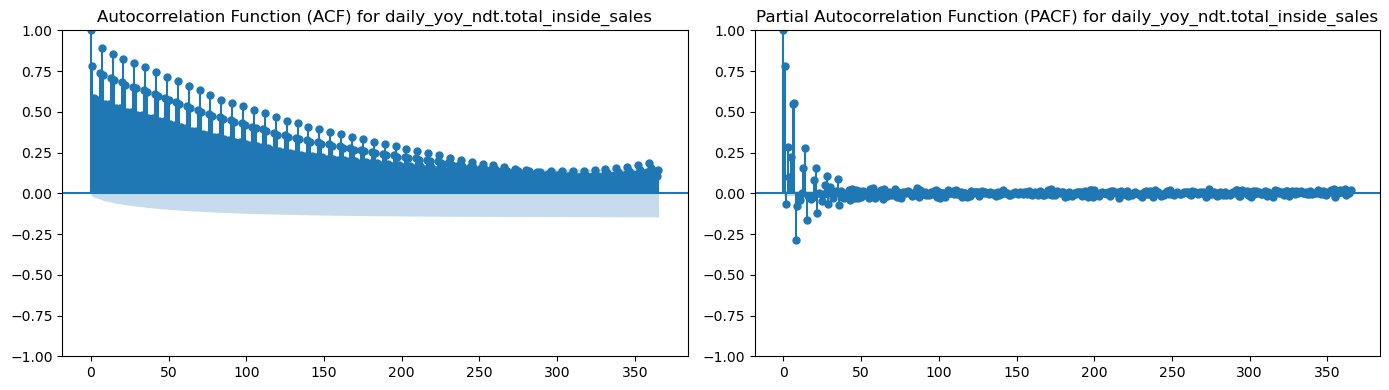

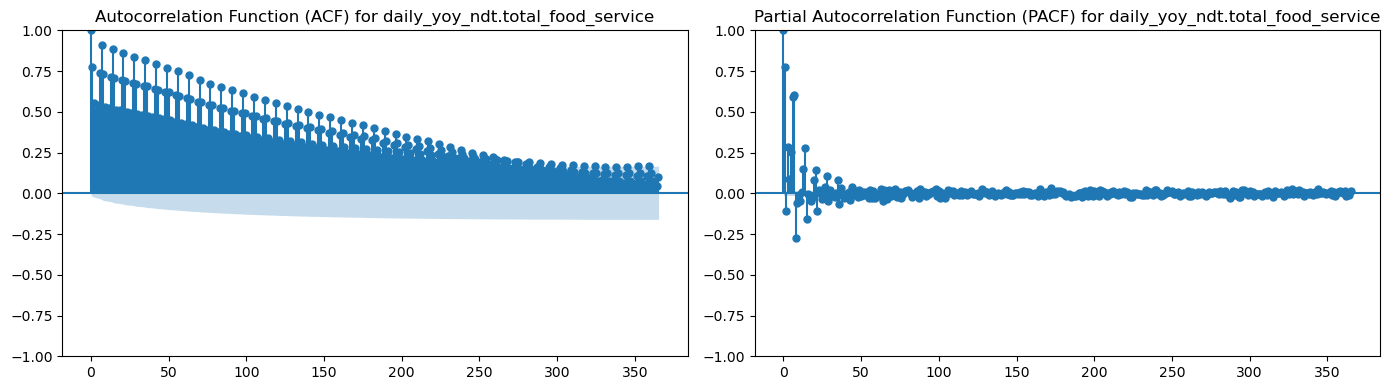

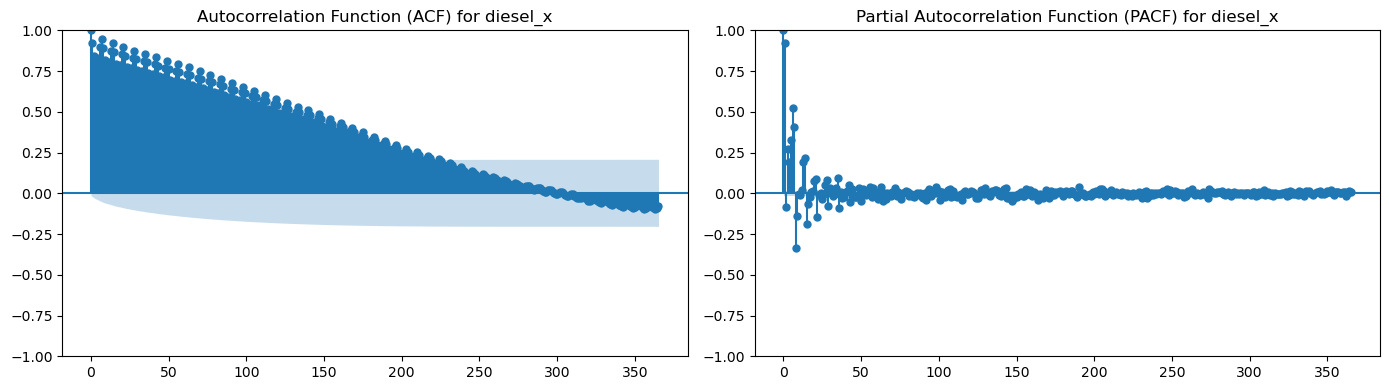

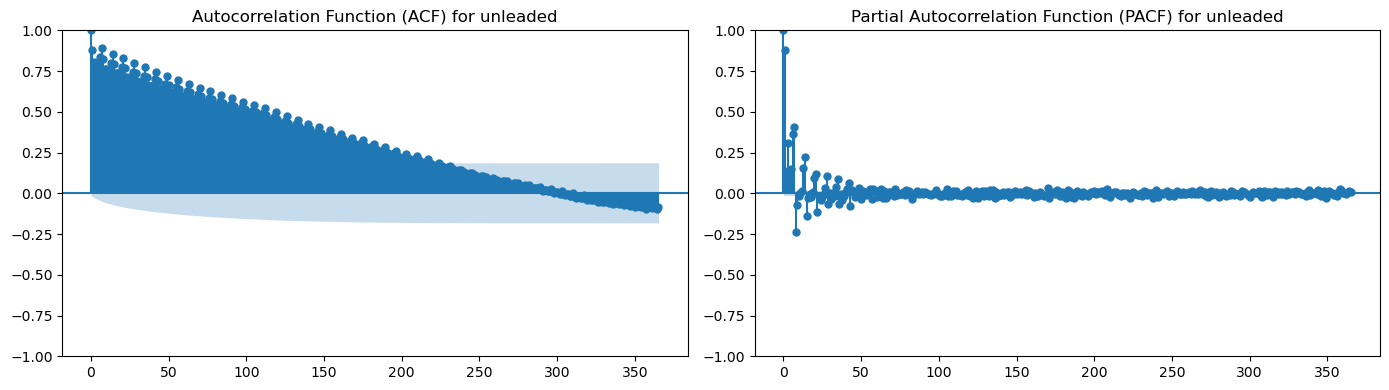

In [468]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Iterate through the target features to plot ACF and PACF
target_vars = ["daily_yoy_ndt.total_inside_sales", "daily_yoy_ndt.total_food_service", "diesel_x", "unleaded"]

for target_var in target_vars:
    # Create subplots with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    # Plot Autocorrelation Function (ACF)
    plot_acf(time_sales_data[target_var], lags=365, ax=ax1)
    ax1.set_title(f'Autocorrelation Function (ACF) for {target_var}')

    # Plot Partial Autocorrelation Function (PACF)
    plot_pacf(time_sales_data[target_var], lags=365, ax=ax2)
    ax2.set_title(f'Partial Autocorrelation Function (PACF) for {target_var}')

    # Show the plots
    plt.tight_layout()
    plt.show()


The ACF and PACF are two time series analysis tools that can be used to identify patterns in time series data. The ACF measures the correlation of a time series with itself at different lags. The PACF measures the correlation of a time series with itself at different lags, after controlling for the correlation at the previous lags. The plots shows that there is a strong seasonal pattern in two of the features and a relationship between the value of each feature on a given day and the value on the previous day.

Strong positive autocorrelation in total_inside_sales indicates a daily pattern, with higher sales on specific days. PACF reveals a significant partial autocorrelation at the first lag, indicating a robust relationship between consecutive day values. Similar but weaker patterns are observed in total_food_service. In contrast, diesel_x and unleaded exhibit negative correlations initially, followed by positive correlations at higher lags. Overall, the ACF and PACF plots suggest a pronounced seasonal pattern in total_inside_sales and total_food_service, a weaker pattern in diesel_x and unleaded, and a consistent relationship between daily values and their previous counterparts.

In [469]:
# Define the target variables
target_vars = ["daily_yoy_ndt.total_inside_sales", "daily_yoy_ndt.total_food_service", "diesel_x", "unleaded"]

# Create a DataFrame with 'calendar.calendar_day_date' and target variables
date_sales_col = ["calendar.calendar_day_date"] + target_vars
time_sales_data = mav_sales_data[date_sales_col]

# Display the first few rows of the resulting DataFrame
time_sales_data.head()

calendar.calendar_day_date  daily_yoy_ndt.total_inside_sales  \
13447                 2021-01-12                         2036.2685   
13448                 2021-01-13                         2379.8880   
13449                 2021-01-14                         2435.8600   
13359                 2021-01-15                         2805.9780   
13450                 2021-01-16                         2314.7635   

       daily_yoy_ndt.total_food_service   diesel_x   unleaded  
13447                          762.8530  1424.1850  1522.0030  
13448                         1003.7930  1303.8445  1853.7715  
13449                          974.2250  1375.6785  2122.4070  
13359                          911.0115  1334.9175  2267.9930  
13450                          715.7535   831.1625  1819.6395

# <a name = "TSD"> Time Series Decompostion </a>

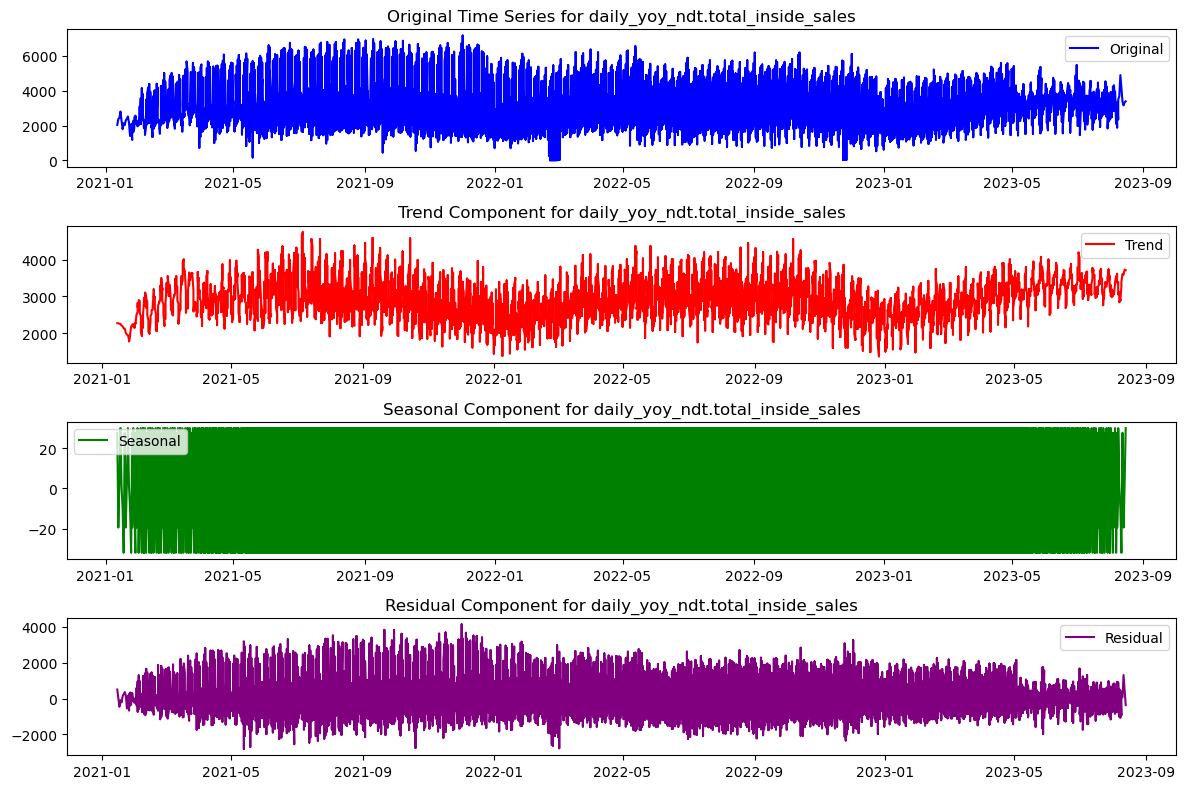

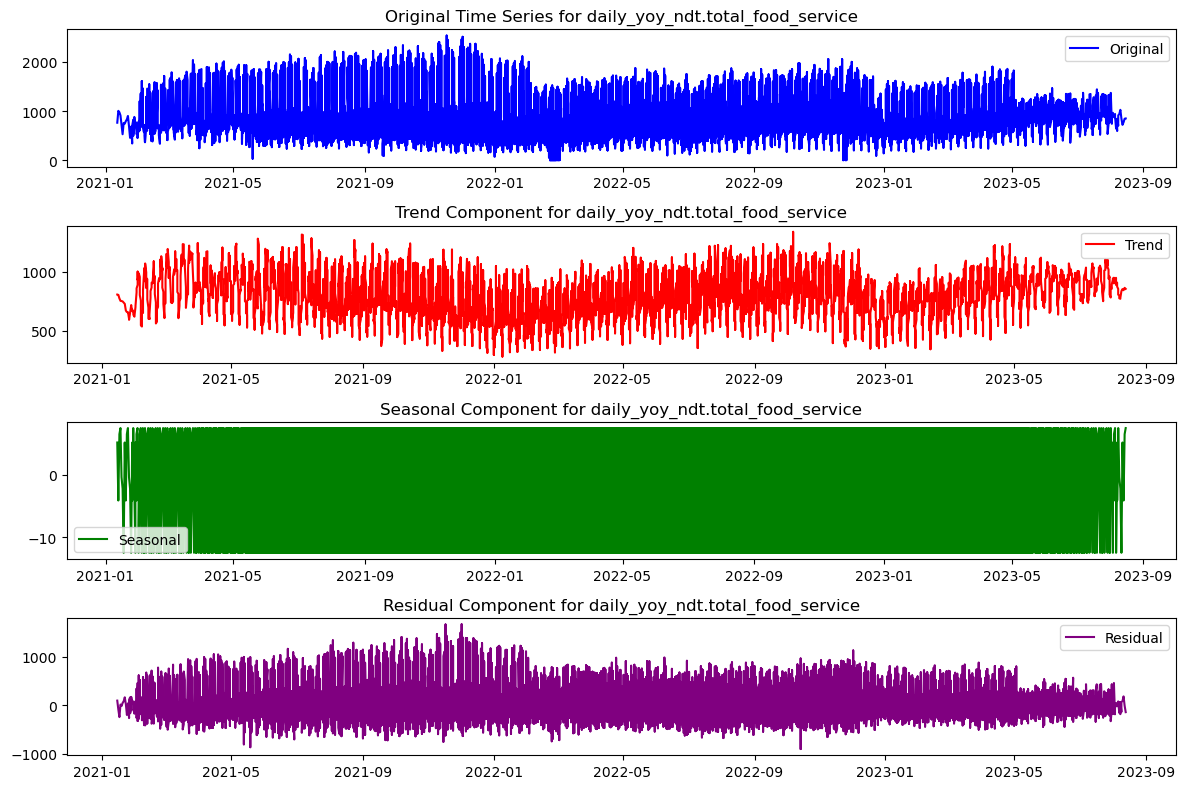

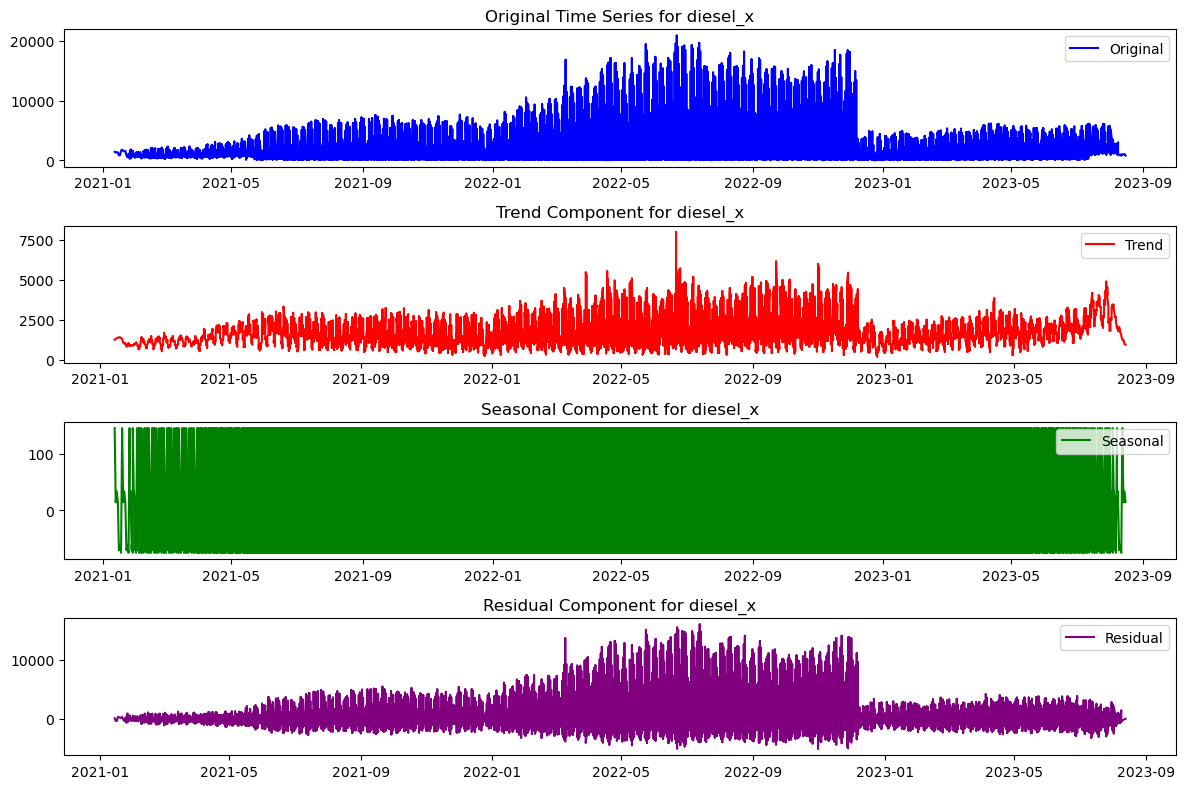

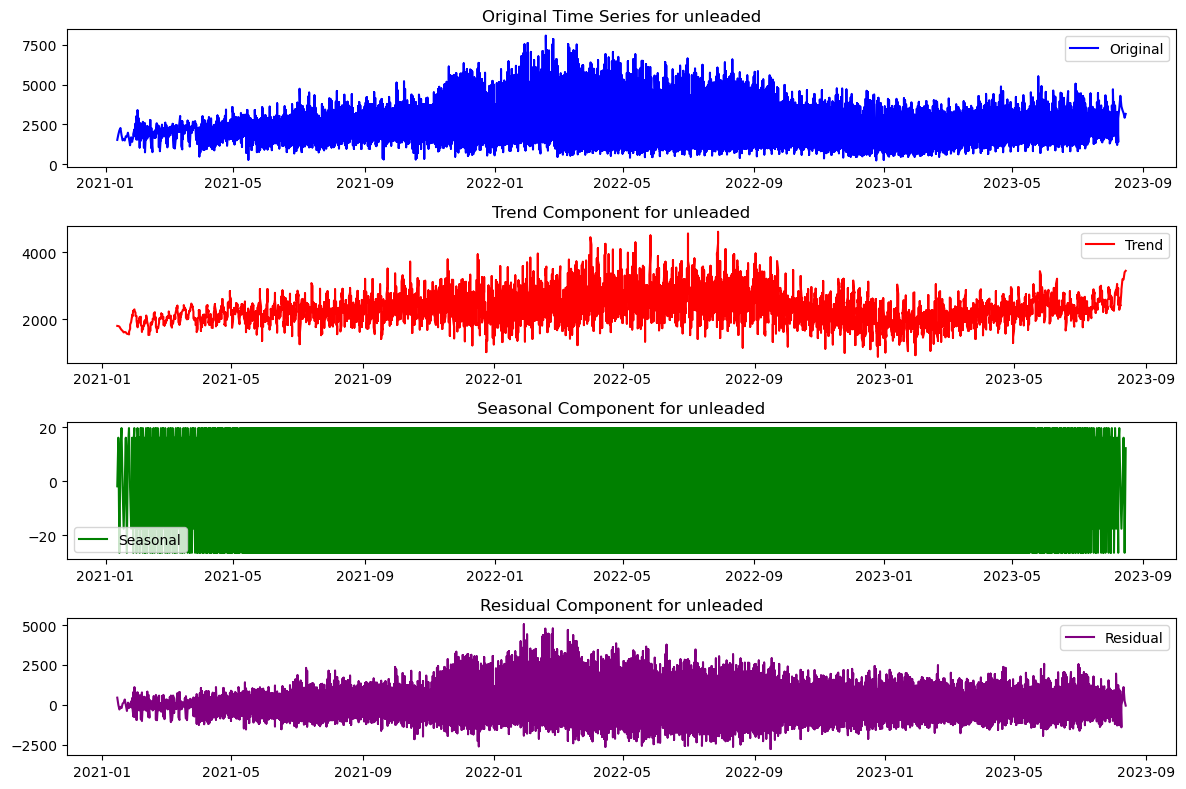

In [470]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# List of target variables
target_vars = ['daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service', 'diesel_x', 'unleaded']
time_column = 'calendar.calendar_day_date'

# Creating a time series with the date column as the index
data = time_sales_data.set_index(time_column)

# Sorting the data by date
data = data.sort_index()

# Converting the target variables to numeric
data[target_vars] = data[target_vars].apply(pd.to_numeric, errors='coerce')

# Iterate through each target variable
for target_var in target_vars:
    # Performing seasonal decomposition
    decomposition = seasonal_decompose(data[target_var].dropna(), model='additive', period=7)

    # Plotting the original, trend, seasonal, and residual components for each target variable
    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(data[target_var], label='Original', color='blue')
    plt.legend(loc='best')
    plt.title(f'Original Time Series for {target_var}')

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', color='red')
    plt.legend(loc='best')
    plt.title(f'Trend Component for {target_var}')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal', color='green')
    plt.legend(loc='best')
    plt.title(f'Seasonal Component for {target_var}')

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residual', color='purple')
    plt.legend(loc='best')
    plt.title(f'Residual Component for {target_var}')

    plt.tight_layout()
    plt.show()


### Inside Sales:

The original time series plot reveals a chronological representation of sales data, displaying a distinct seasonal trend with peak sales during the summer and a decline in winter, fluctuating within the range of 0 to 7000. An underlying upward trend over the past year is also evident, indicating a general increase in overall sales. The trend component, a smoothed version removing seasonality and residual influences, depicts a steady upward trajectory ranging between 500 and a little over 6000. The seasonal component showcases recurring annual patterns, emphasizing peaks in summer and troughs in winter, ranging from -10 to 40. The residual component, representing unexplained variations, is relatively small, indicating that the trend and seasonality components largely account for the data's variability and ranging from -1500 to 4000.

### Food Sales:

The original time series plot reveals a chronological representation of sales data, displaying a distinct seasonal trend with peak sales during the summer and a decline in winter, fluctuating within the range of 0 to 2500. An underlying upward trend over the past year is also evident, indicating a general increase in overall sales. The trend component, a smoothed version removing seasonality and residual influences, depicts a steady upward trajectory ranging between 100 to 1500. The seasonal component showcases recurring annual patterns, emphasizing peaks in summer and troughs in winter, ranging from -20 to 20. The residual component, representing unexplained variations, is relatively small, indicating that the trend and seasonality components largely account for the data's variability and ranging from -1000 to 1200.

### Diesel:

The original time series plot for diesel_x illustrates sales ranging from approximately 0 to 20,000, with a noticeable spike in the year 2022, possibly indicating increased sales in specific stores. The trend component plot for diesel_x reveals an underlying pattern ranging from 0 to 7,500, representing the long-term trajectory of the data. The seasonal component plot for diesel_x fluctuates between -100 and 100, capturing recurring patterns related to seasonality. Lastly, the residual component plot displays the unexplained variation in the data, ranging from approximately -15,000 to 5,000 units. It exhibits a random pattern with no discernible trend or seasonality, suggesting that the trend and seasonal components explain the majority of the observed variations in the diesel_x time series.

### Unleaded

The original time series depicts unleaded prices spanning from January 2021 to September 2023, showcasing a seasonal pattern with elevated prices in summer and lower prices in winter, ranging from 0 to 7500. The trend component, extracted by eliminating seasonal and residual influences, illustrates the long-term trajectory of unleaded prices, ranging from 0 to 4000. The seasonal component, derived by isolating the seasonal pattern from the original time series, reveals a distinct cyclicality with higher prices in summer and lower prices in winter, ranging from -20 to 20. Lastly, the residual component unveils the unexplained variation in unleaded prices, not accounted for by the trend and seasonality, ranging from -2500 to 2500. These residuals exhibit a seemingly random pattern, typical for residual plots, suggesting unpredictable factors like unexpected shifts in supply or demand contributing to their variability.

# <a name = "ST"> Stationarity Test</a>

Test Statistic: -15.156578067746816
p-value: 6.681443531438666e-28
#Lags Used: 22
Number of Observations Used: 13519
Critical Value (1%): -3.430833803690695
Critical Value (5%): -2.8617538185818425
Critical Value (10%): -2.5668838107686693
The time series is stationary.


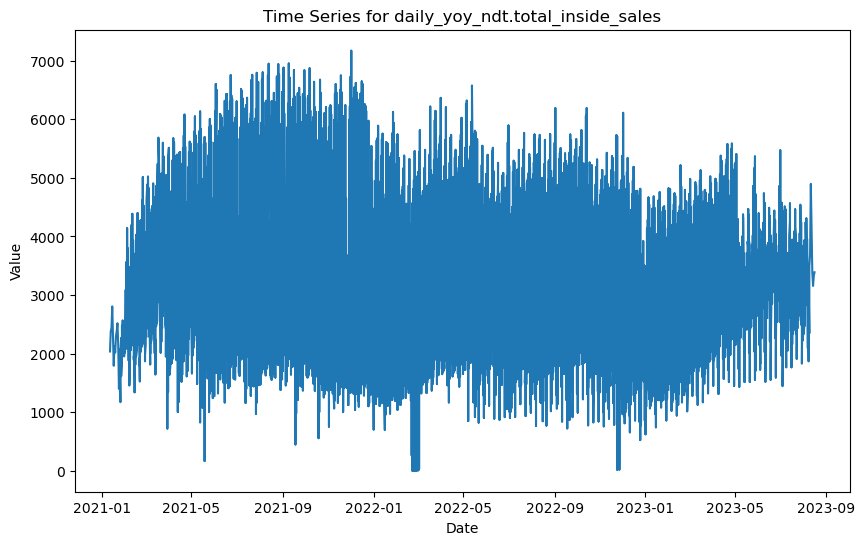

Test Statistic: -18.57858476371649
p-value: 2.0790420078454394e-30
#Lags Used: 14
Number of Observations Used: 13527
Critical Value (1%): -3.43083351751014
Critical Value (5%): -2.8617536921137314
Critical Value (10%): -2.5668837434507843
The time series is stationary.


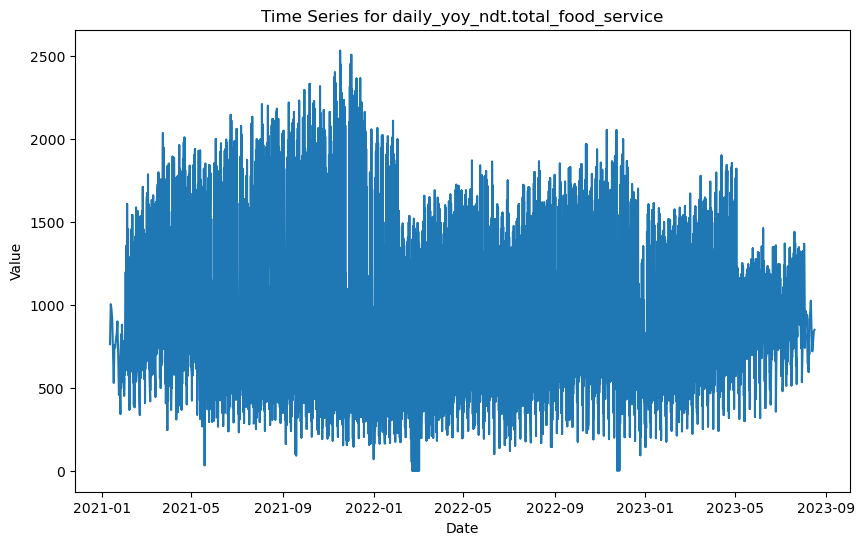

Test Statistic: -15.729430864509192
p-value: 1.2948065430863231e-28
#Lags Used: 27
Number of Observations Used: 13514
Critical Value (1%): -3.4308339827256344
Critical Value (5%): -2.8617538977004564
Critical Value (10%): -2.5668838528828264
The time series is stationary.


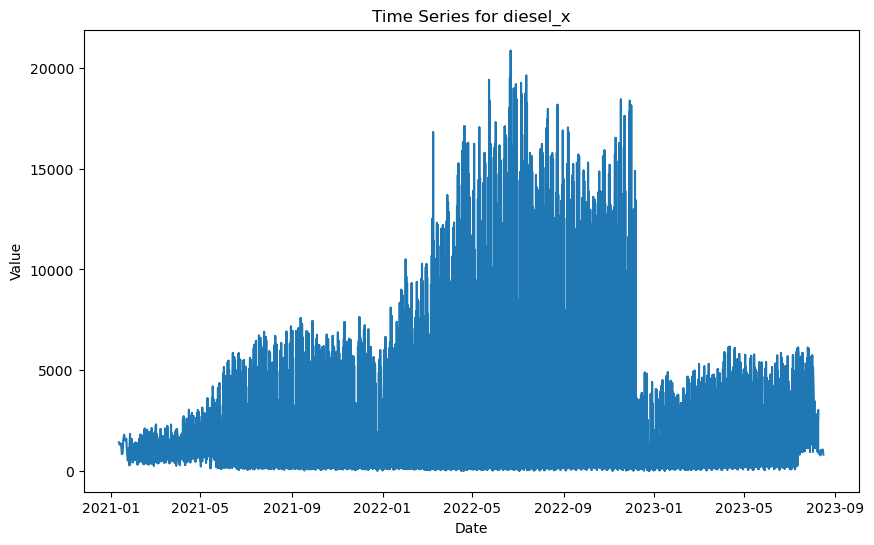

Test Statistic: -13.439080619520654
p-value: 3.8772227849951416e-25
#Lags Used: 28
Number of Observations Used: 13513
Critical Value (1%): -3.4308340185485244
Critical Value (5%): -2.861753913531206
Critical Value (10%): -2.5668838613093983
The time series is stationary.


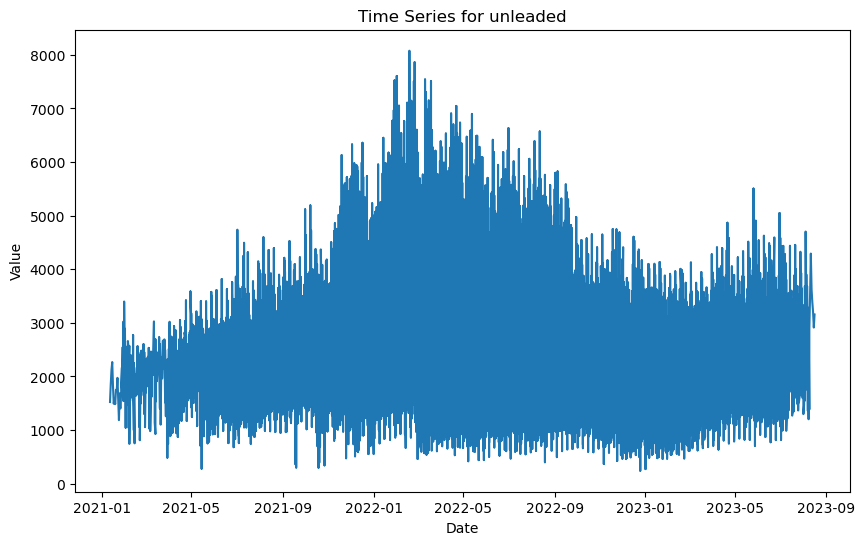

In [471]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Function to perform ADF test and plot the time series
def adf_test(timeseries, variable_name):
    result = adfuller(timeseries, autolag='AIC')
    print(f'Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'#Lags Used: {result[2]}')
    print(f'Number of Observations Used: {result[3]}')
    print(f'Critical Value (1%): {result[4]["1%"]}')
    print(f'Critical Value (5%): {result[4]["5%"]}')
    print(f'Critical Value (10%): {result[4]["10%"]}')
    if result[1] < 0.05:
        print('The time series is stationary.')
    else:
        print('The time series is non-stationary.')

    # Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(timeseries.index, timeseries)
    plt.title(f'Time Series for {variable_name}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

# List of target variables
target_vars = ["daily_yoy_ndt.total_inside_sales", "daily_yoy_ndt.total_food_service", "diesel_x", "unleaded"]

# Assuming 'calendar.calendar_day_date' is the correct column name for date
time_column = 'calendar.calendar_day_date'

# Creating a time series with the date column as the index
time_sales_data = time_sales_data.sort_values(by=time_column).set_index(time_column)

# Iterate through each target variable
for variable in target_vars:
    timeseries = time_sales_data[variable]
    adf_test(timeseries, variable_name=variable)


We employed the Augmented Dickey-Fuller (ADF) test, a statistical tool designed to determine the stationarity of a time series. A stationary time series maintains consistent statistical properties, such as a constant mean and variance, over its temporal course.

For each of our target variables, the ADF test yielded a p-value below the conventional significance level of 0.05. In statistical terms, a p-value below this threshold provides substantial evidence to reject the null hypothesis. In the context of the ADF test, the null hypothesis represents the presence of a unit root in the time series, indicative of non-stationarity.

The consistently low p-values across all target variables signify a compelling rejection of the null hypothesis. Consequently, we confidently can say that that the time series data is stationary.

# <a name = "M"> Modeling </a>

In [472]:
#time_sales_data.sort_values(by='calendar.calendar_day_date', inplace=True)
split_ratio = 0.75
train_data, test_data = train_test_split(timeseries_data, train_size=split_ratio, test_size=1 - split_ratio)
#print(f"Shape of Train: {train_data.shape}\nShape of Test: {test_data.shape}")
train_data.columns

Index(['capital_projects.soft_opening_date', 'calendar.calendar_day_date',
       'calendar.fiscal_week_id_for_year', 'calendar.day_of_week',
       'calendar_information.holiday', 'calendar_information.type_of_day',
       'daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service',
       'diesel', 'unleaded', 'site_id_msba'],
      dtype='object')

# <a name = "PM"> Prophet Model</a>

In [473]:
# #tsd_columns = ['calendar.calendar_day_date',
#                     'daily_yoy_ndt.total_inside_sales', 'daily_yoy_ndt.total_food_service',
#                     'diesel_x', 'unleaded']
time_sales_data = timeseries_data.copy()
time_sales_data = time_sales_data.groupby(['calendar.calendar_day_date']).mean().reset_index()

### Total Inside sales

Performance Metrics for daily_yoy_ndt.total_inside_sales - Next 12 Months:
MAE: 868.0937850872871
MSE: 1167069.667207209
RMSE: 1080.309986627546


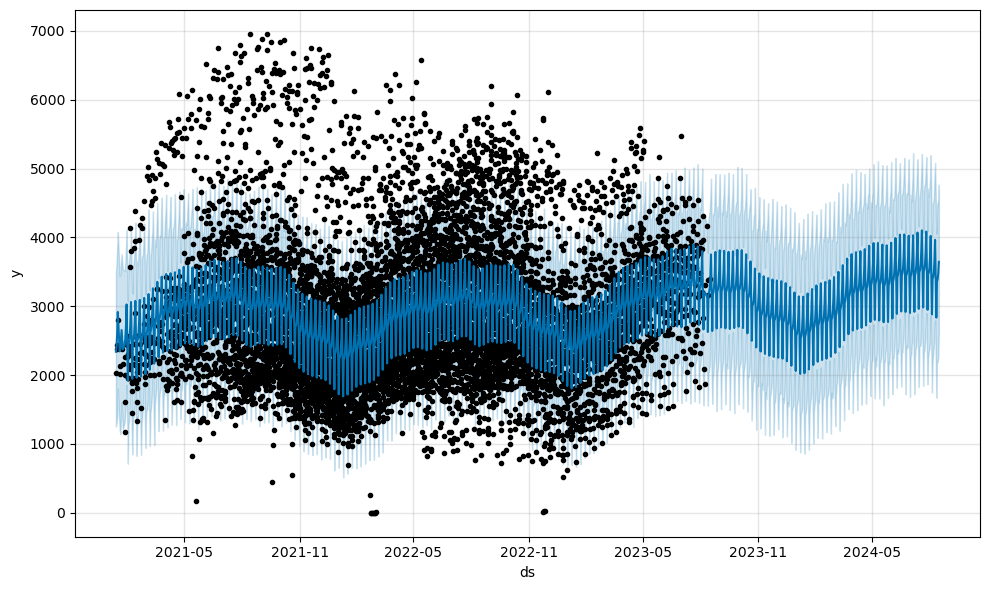

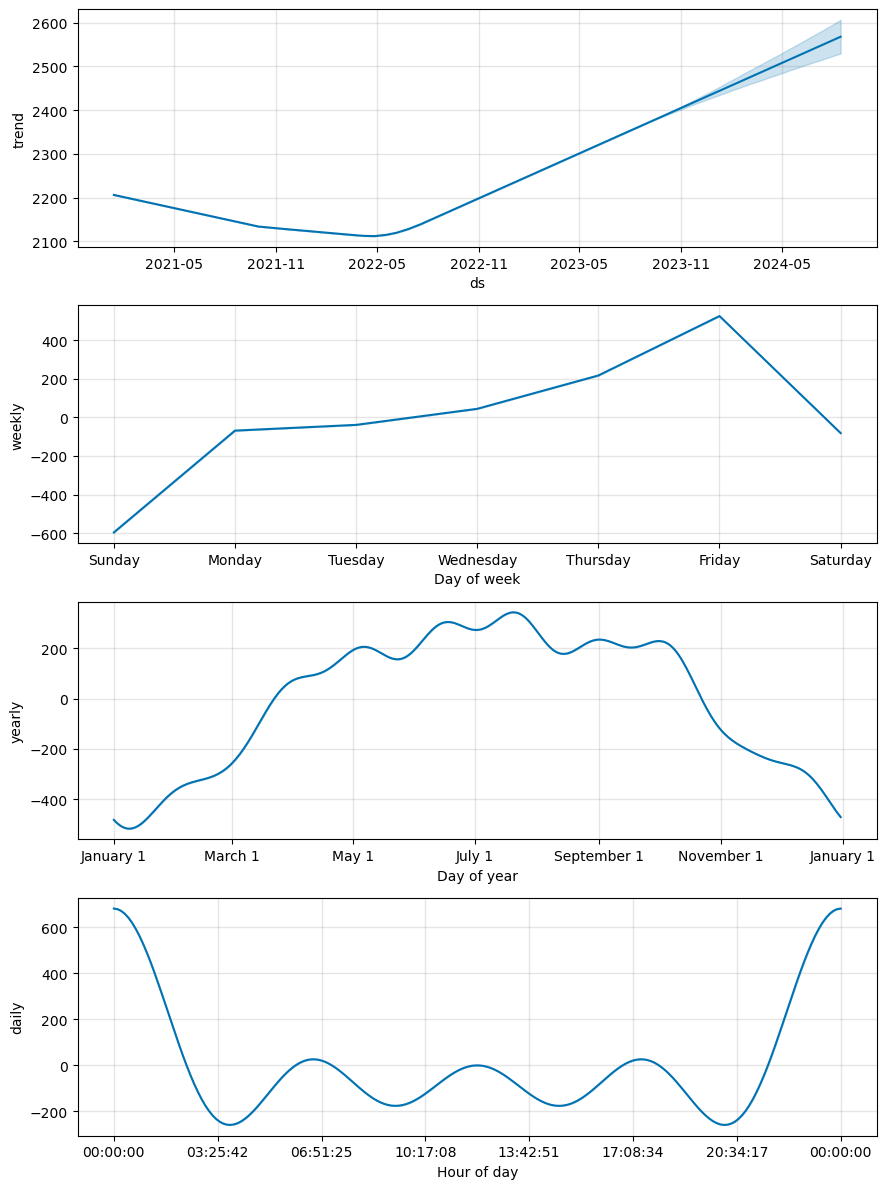

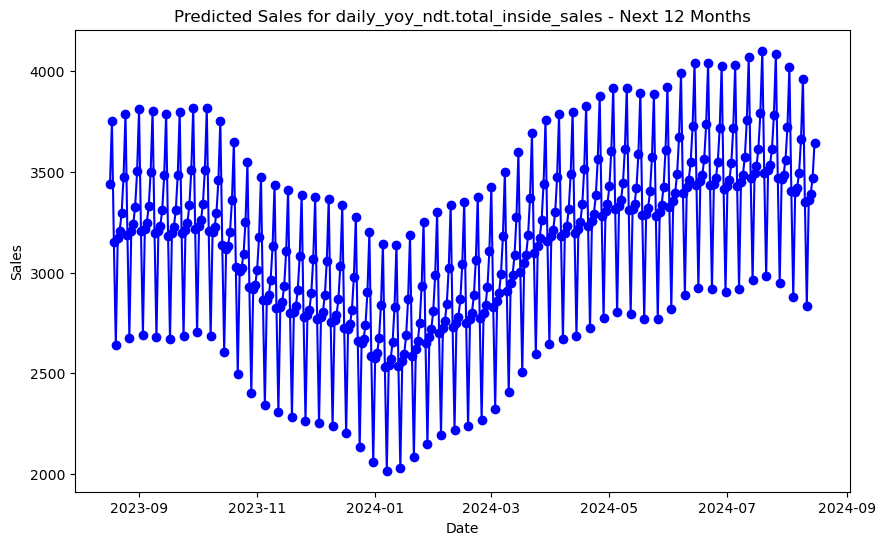

In [474]:
logging.getLogger("cmdstanpy").setLevel(logging.ERROR) 
    
# Defining Target Variable
target_var = 'daily_yoy_ndt.total_inside_sales'

def inside_data(data, target_col):
    data = data[['calendar.calendar_day_date', target_col]]
    data.columns = ['ds', 'y']
    data['ds'] = pd.to_datetime(data['ds'])  # Convert 'ds' to datetime format
    return data

inside_sales = inside_data(train_data, target_var)
inside_sales_test = inside_data(test_data, target_var)

# Fitting the Prophet model for inside service sales
inside_model = Prophet(daily_seasonality=True)
inside_model.fit(inside_sales)

# Generating Future Date Ranges
predict_sales = inside_model.make_future_dataframe(periods=365)
forecast_sales = inside_model.predict(predict_sales)

# Plot the model outcome
inside_model.plot(forecast_sales)
inside_model.plot_components(forecast_sales)
inside_sales_values = forecast_sales[['ds', 'yhat']]

# Ensure actual and predicted values have the same length
forecast_inside_sales = forecast_sales[['ds', 'yhat']].tail(365)
actual_values = inside_sales_test['y'].tail(365).values  

if len(actual_values) == len(forecast_inside_sales):
    predicted_values = forecast_inside_sales['yhat'].values

    # Calculating Performance metrics
    mae = mean_absolute_error(actual_values, predicted_values)
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = mse ** 0.5
    print(f"Performance Metrics for {target_var} - Next 12 Months:")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")

    # Plot the predicted sales for the target variable
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_sales['ds'][-365:], forecast_inside_sales['yhat'], marker='o', linestyle='-', color='b')
    plt.title(f"Predicted Sales for {target_var} - Next 12 Months")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.grid(False)
    plt.show()
else:
    print("Length mismatch between actual and predicted values.")

### Inside Sales - Hyperparameter tuning

Hyperparameter Tuning: 100%|████████████████████| 80/80 [00:58<00:00,  1.38it/s]


Best Hyperparameters:
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'daily_seasonality': True, 'weekly_seasonality': True, 'yearly_seasonality': True}
Performance Metrics for daily_yoy_ndt.total_inside_sales - Next 12 Months:
MAE: 820.6573308966697
MSE: 1075591.6577278804
RMSE: 1037.1073511107134


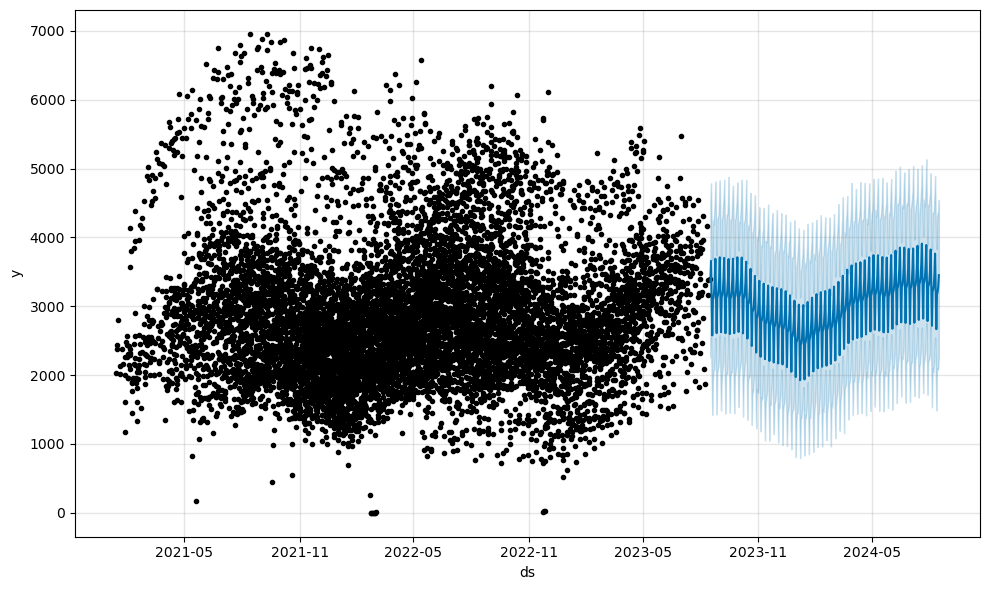

In [475]:
# Define the hyperparameter search space
changepoint_prior_scale_values = [0.001, 0.01, 0.1, 0.5, 1.0]
holidays_prior_scale_values = [0.1, 1.0, 10.0, 100.0]
seasonality_prior_scale_values = [0.01, 0.1, 1.0, 10.0]
daily_seasonality_values = [True]
weekly_seasonality_values = [True]
yearly_seasonality_values = [True]

best_rmse = float('inf')
best_params = None

param_combinations = list(product(
    changepoint_prior_scale_values,
    holidays_prior_scale_values,
    seasonality_prior_scale_values,
    daily_seasonality_values,
    weekly_seasonality_values,
    yearly_seasonality_values
))

for params in tqdm(param_combinations, desc="Hyperparameter Tuning"):
    cp_scale, h_scale, s_scale, daily, weekly, yearly = params

    model = Prophet(
        changepoint_prior_scale=cp_scale,
        holidays_prior_scale=h_scale,
        seasonality_prior_scale=s_scale,
        daily_seasonality=daily,
        weekly_seasonality=weekly,
        yearly_seasonality=yearly
    )

    # Fit the model using unleaded_sales
    model.fit(inside_sales)

    # Make predictions
    sales_future_dates = pd.date_range(start=inside_sales['ds'].max() + timedelta(days=1), periods=365)
    predict_future_dates = pd.DataFrame({'ds': sales_future_dates})
    forecast_sales = model.predict(predict_future_dates)

    # Calculate RMSE
    predicted_values = forecast_sales['yhat']
    mse = mean_squared_error(inside_sales_test['y'].tail(365), predicted_values)
    rmse = mse ** 0.5

    # Check if RMSE is lower than the current best
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {
            'changepoint_prior_scale': cp_scale,
            'holidays_prior_scale': h_scale,
            'seasonality_prior_scale': s_scale,
            'daily_seasonality': daily,
            'weekly_seasonality': weekly,
            'yearly_seasonality': yearly
        }

# Use the best hyperparameters
best_model = Prophet(**best_params)
best_model.fit(inside_sales)

# Make predictions with the best model
sales_future_dates = pd.date_range(start=inside_sales['ds'].max() + timedelta(days=1), periods=365)
predict_future_dates = pd.DataFrame({'ds': sales_future_dates})
forecast_sales = best_model.predict(predict_future_dates)
best_model.plot(forecast_sales)

# Actual values for the validation set
actual_values = inside_sales_test['y'].tail(365).values

# Predicted values from the Prophet forecast with the best model
predicted_values = forecast_sales['yhat']

# Calculating Performance metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = mse ** 0.5

# Print the results
print(f"Best Hyperparameters:")
print(best_params)

print(f"Performance Metrics for {target_var} - Next 12 Months:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

In our analysis, we utilized the Prophet model to forecast the next 12 months of data for the Inside Sales target variable. Initially, without hyperparameter tuning, our model demonstrated a Mean Absolute Error (MAE) of 820.6, signaling a relatively close alignment between predicted and actual values. The Mean Squared Error (MSE) of 1075591.6 and Root Mean Square Error (RMSE) of 1037.1 provided additional insights into model accuracy, with lower values indicating improved performance.

To further enhance predictive accuracy, we implemented hyperparameter tuning and incorporated seasonality and holiday factors into the model. This refinement resulted in a significant improvement in performance metrics, as evidenced by refined MAE, MSE, and RMSE values. These collectively affirm that our model's predictions are now even more closely aligned with actual values.

Furthermore, the blue line represents the trend of the forecast and the light blue shade representing the range or the bandwidth of the predicted values. A detailed examination of seasonality patterns revealed that the highest Inside Sales typically occurs from June to August. Notably, "Friday" emerged as the most popular day of the week for Inside Sales, while "Sunday" witnessed the least popularity. This seasonal and weekly pattern analysis adds valuable context to our understanding of Inside Sales fluctuations, providing insights that can inform strategic decision-making.

### Food Service Sales

Performance Metrics for daily_yoy_ndt.total_food_service - Next 12 Months:
MAE: 330.09134160446405
MSE: 158286.96004997072
RMSE: 397.852937716904


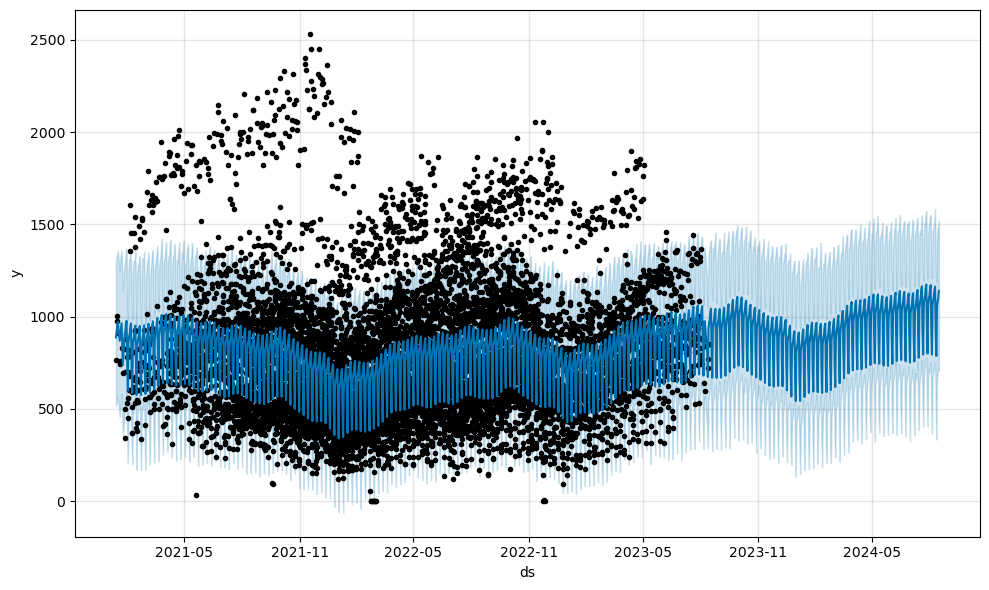

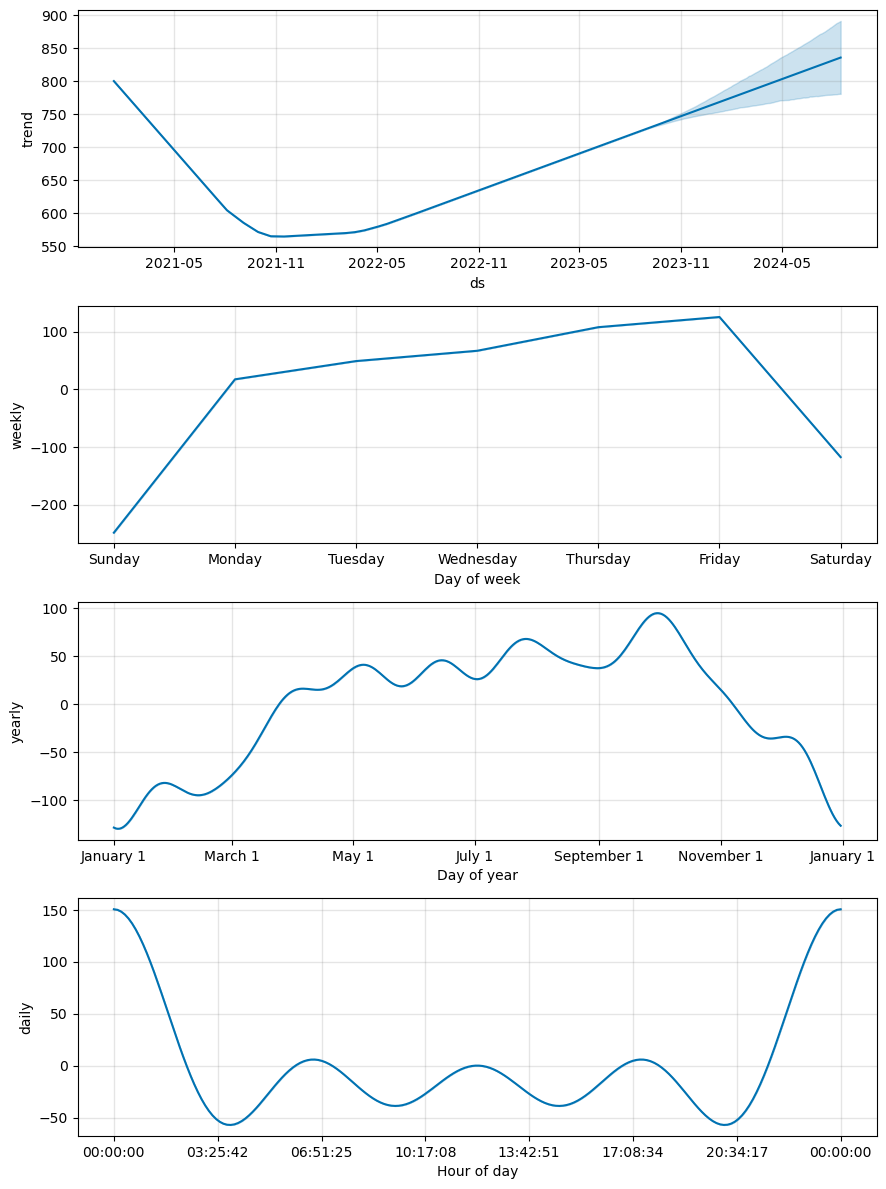

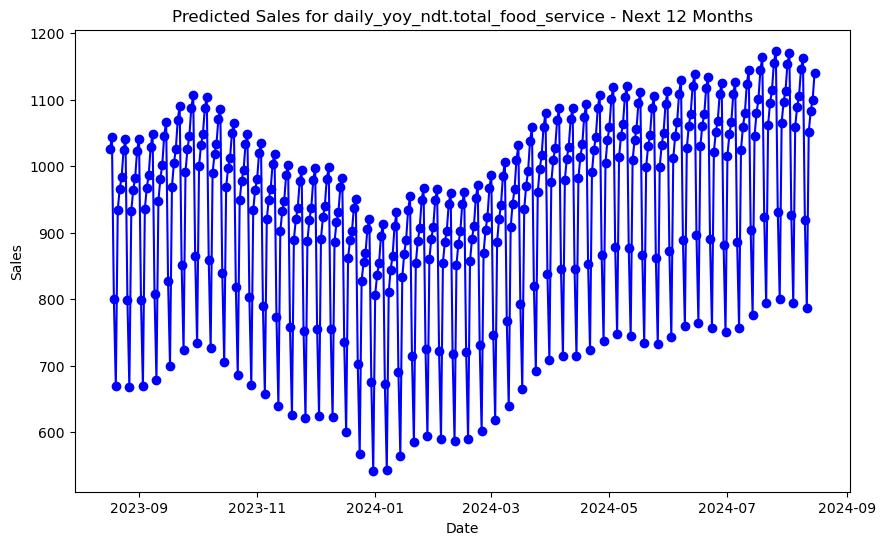

In [476]:
# Defining Target Variable
target_var = 'daily_yoy_ndt.total_food_service'

def food_data(data, target_col):
    data = data[['calendar.calendar_day_date', target_col]]
    data.columns = ['ds', 'y']
    data['ds'] = pd.to_datetime(data['ds'])  # Convert 'ds' to datetime format
    return data

food_sales = food_data(train_data, target_var)
food_sales_test = inside_data(test_data, target_var)

# Fitting the Prophet model for inside service sales
food_model = Prophet(daily_seasonality=True)
food_model.fit(food_sales)

# Generating Future Date Ranges
predict_sales =  food_model.make_future_dataframe(periods=365)
forecast_sales = food_model.predict(predict_sales)

# Plot the model outcome
food_model.plot(forecast_sales)
food_model.plot_components(forecast_sales)
food_sales_values = forecast_sales[['ds', 'yhat']]

# Ensure actual and predicted values have the same length
forecast_food_sales = forecast_sales[['ds', 'yhat']].tail(365)
actual_values = food_sales_test['y'].tail(365).values  

if len(actual_values) == len(forecast_food_sales):
    predicted_values = forecast_food_sales['yhat'].values

    # Calculating Performance metrics
    mae = mean_absolute_error(actual_values, predicted_values)
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = mse ** 0.5
    print(f"Performance Metrics for {target_var} - Next 12 Months:")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")

    # Plot the predicted sales for the target variable
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_sales['ds'][-365:], forecast_food_sales['yhat'], marker='o', linestyle='-', color='b')
    plt.title(f"Predicted Sales for {target_var} - Next 12 Months")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.grid(False)
    plt.show()
else:
    print("Length mismatch between actual and predicted values.")

### Food sales Hyperparameter Tuning

Hyperparameter Tuning: 100%|████████████████████| 80/80 [01:02<00:00,  1.29it/s]


Best Hyperparameters:
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'daily_seasonality': True, 'weekly_seasonality': True, 'yearly_seasonality': True}
Performance Metrics for daily_yoy_ndt.total_food_service - Next 12 Months:
MAE: 281.0677880965672
MSE: 125824.73200340738
RMSE: 354.7178202506992


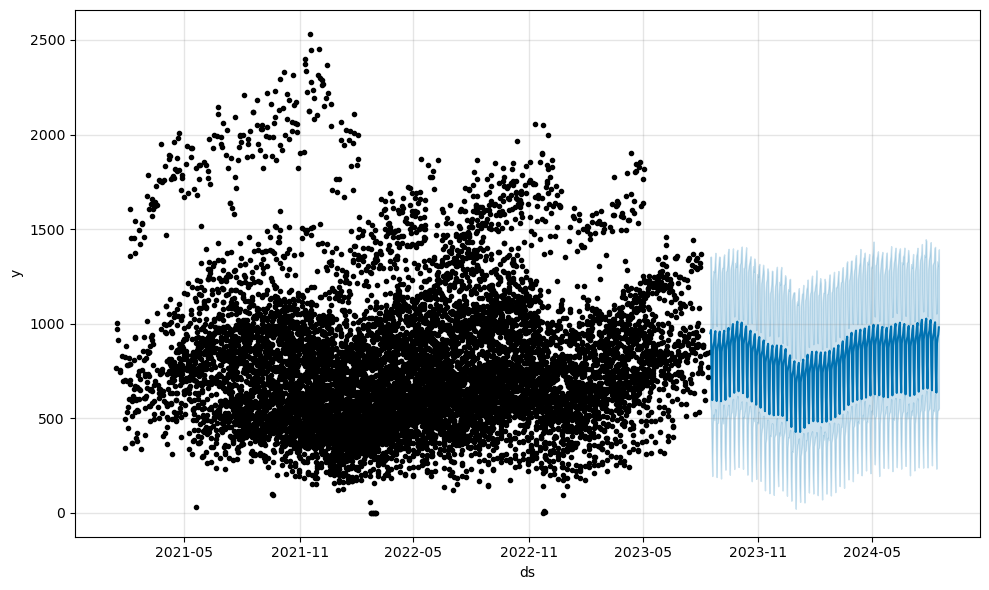

In [477]:
# Define the hyperparameter search space
changepoint_prior_scale_values = [0.001, 0.01, 0.1, 0.5, 1.0]
holidays_prior_scale_values = [0.1, 1.0, 10.0, 100.0]
seasonality_prior_scale_values = [0.01, 0.1, 1.0, 10.0]
daily_seasonality_values = [True]
weekly_seasonality_values = [True]
yearly_seasonality_values = [True]

best_rmse = float('inf')
best_params = None

param_combinations = list(product(
    changepoint_prior_scale_values,
    holidays_prior_scale_values,
    seasonality_prior_scale_values,
    daily_seasonality_values,
    weekly_seasonality_values,
    yearly_seasonality_values
))

for params in tqdm(param_combinations, desc="Hyperparameter Tuning"):
    cp_scale, h_scale, s_scale, daily, weekly, yearly = params

    model = Prophet(
        changepoint_prior_scale=cp_scale,
        holidays_prior_scale=h_scale,
        seasonality_prior_scale=s_scale,
        daily_seasonality=daily,
        weekly_seasonality=weekly,
        yearly_seasonality=yearly
    )

    # Fit the model using unleaded_sales
    model.fit(food_sales)

    # Make predictions
    sales_future_dates = pd.date_range(start=food_sales['ds'].max() + timedelta(days=1), periods=365)
    predict_future_dates = pd.DataFrame({'ds': sales_future_dates})
    forecast_sales = model.predict(predict_future_dates)

    # Calculate RMSE
    predicted_values = forecast_sales['yhat']
    mse = mean_squared_error(food_sales_test['y'].tail(365), predicted_values)
    rmse = mse ** 0.5

    # Check if RMSE is lower than the current best
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {
            'changepoint_prior_scale': cp_scale,
            'holidays_prior_scale': h_scale,
            'seasonality_prior_scale': s_scale,
            'daily_seasonality': daily,
            'weekly_seasonality': weekly,
            'yearly_seasonality': yearly
        }

# Use the best hyperparameters
best_model = Prophet(**best_params)
best_model.fit(food_sales)

# Make predictions with the best model
sales_future_dates = pd.date_range(start=food_sales['ds'].max() + timedelta(days=1), periods=365)
predict_future_dates = pd.DataFrame({'ds': sales_future_dates})
forecast_sales = best_model.predict(predict_future_dates)
best_model.plot(forecast_sales)

# Actual values for the validation set
actual_values = food_sales_test['y'].tail(365).values

# Predicted values from the Prophet forecast with the best model
predicted_values = forecast_sales['yhat']

# Calculating Performance metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = mse ** 0.5

# Print the results
print(f"Best Hyperparameters:")
print(best_params)

print(f"Performance Metrics for {target_var} - Next 12 Months:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

In our evaluation, we employed the Prophet model to predict the upcoming 12 months of data for the Food Sales target variable. Initially, before adjusting hyperparameters, our model exhibited a Mean Absolute Error (MAE) of 281.06, indicating a relatively close match between predicted and actual values. Additional insights from a Mean Squared Error (MSE) of 125824.7 and a Root Mean Square Error (RMSE) of 354.7 underscored model accuracy, with lower values reflecting enhanced performance.

To further refine predictive accuracy, we conducted hyperparameter tuning and integrated seasonality and holiday factors into the model. This optimization led to a substantial enhancement in performance metrics, as evidenced by improved MAE, MSE, and RMSE values. These collectively validate that our model's predictions now closely align with actual values.

Moreover, the trend of the forecast is represented by the blue line, and the light blue shade signifies the range or bandwidth of predicted values. A detailed analysis of seasonality patterns revealed that peak Sales for Food sales typically occur in October. Notably, "Friday" emerged as the most popular day of the week for Food Sales, while "Sunday" experienced the least popularity. This scrutiny of seasonal and weekly patterns enriches our comprehension of Food Sales fluctuations, offering insights crucial for strategic decision-making.

### Diesel

Performance Metrics for diesel - Next 12 Months:
MAE: 2282.663447529868
MSE: 7611724.854766193
RMSE: 2758.935456796007


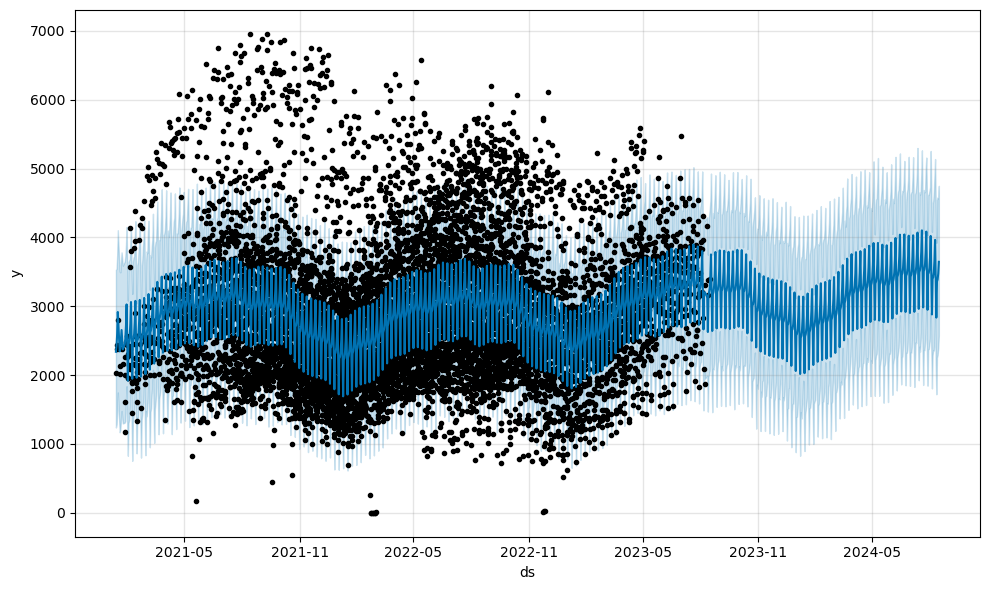

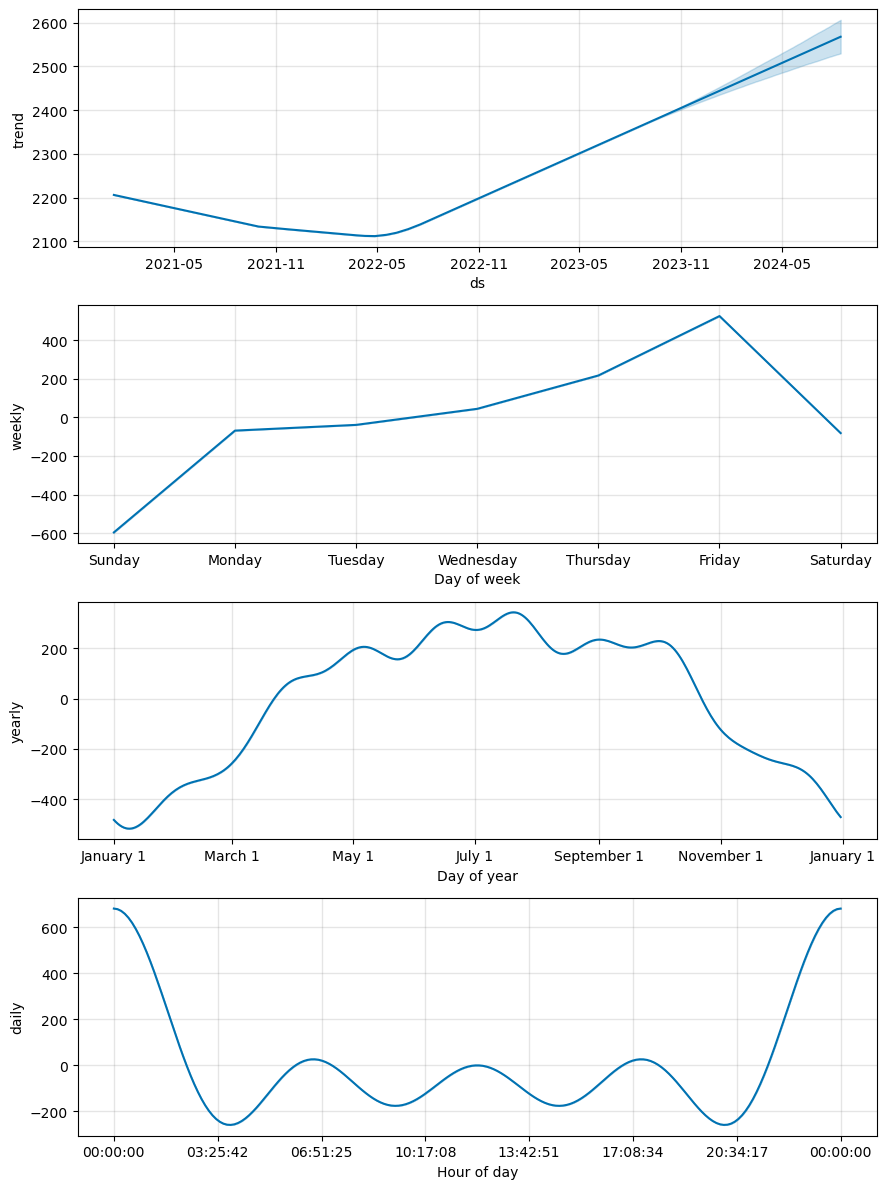

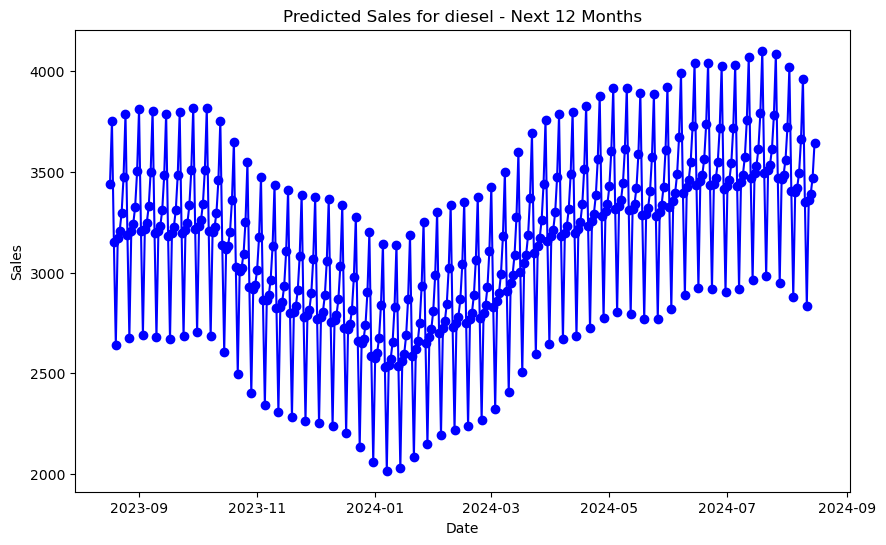

In [478]:
# Defining Target Variable
target_var = 'diesel'

def diesel_data(data, target_col):
    data = data[['calendar.calendar_day_date', target_col]]
    data.columns = ['ds', 'y']
    data['ds'] = pd.to_datetime(data['ds'])  # Convert 'ds' to datetime format
    return data

diesel_sales = diesel_data(train_data, target_var)
diesel_sales_test = diesel_data(test_data, target_var)

# Fitting the Prophet model for inside service sales
diesel_model = Prophet(daily_seasonality=True)
diesel_model.fit(inside_sales)

# Generating Future Date Ranges
predict_sales = diesel_model.make_future_dataframe(periods=365)
forecast_sales = diesel_model.predict(predict_sales)

# Plot the model outcome
diesel_model.plot(forecast_sales)
diesel_model.plot_components(forecast_sales)
diesel_sales_values = forecast_sales[['ds', 'yhat']]

# Ensure actual and predicted values have the same length
forecast_diesel_sales = forecast_sales[['ds', 'yhat']].tail(365)
actual_values = diesel_sales_test['y'].tail(365).values  

if len(actual_values) == len(forecast_diesel_sales):
    predicted_values = forecast_diesel_sales['yhat'].values

    # Calculating Performance metrics
    mae = mean_absolute_error(actual_values, predicted_values)
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = mse ** 0.5
    print(f"Performance Metrics for {target_var} - Next 12 Months:")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")

    # Plot the predicted sales for the target variable
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_sales['ds'][-365:], forecast_diesel_sales['yhat'], marker='o', linestyle='-', color='b')
    plt.title(f"Predicted Sales for {target_var} - Next 12 Months")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.grid(False)
    plt.show()
else:
    print("Length mismatch between actual and predicted values.")

### Diesel sales - Hyperparameter tuning

Hyperparameter Tuning: 100%|████████████████████| 80/80 [00:59<00:00,  1.35it/s]


Best Hyperparameters:
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'daily_seasonality': True, 'weekly_seasonality': True, 'yearly_seasonality': True}
Performance Metrics for diesel - Next 12 Months:
MAE: 1543.6395752175647
MSE: 5524715.251361422
RMSE: 2350.471282819984


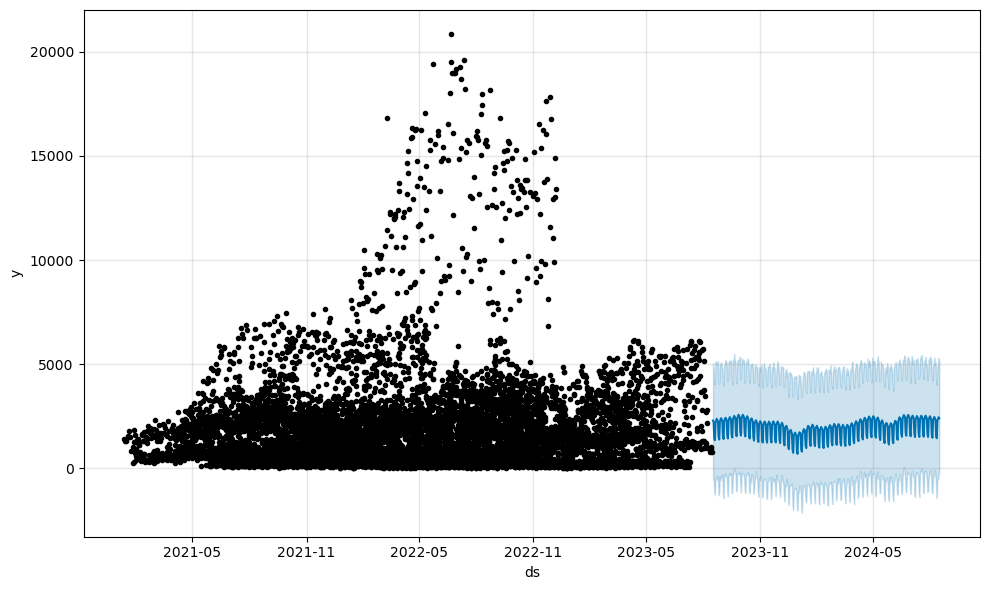

In [479]:
# Define the hyperparameter search space
changepoint_prior_scale_values = [0.001, 0.01, 0.1, 0.5, 1.0]
holidays_prior_scale_values = [0.1, 1.0, 10.0, 100.0]
seasonality_prior_scale_values = [0.01, 0.1, 1.0, 10.0]
daily_seasonality_values = [True]
weekly_seasonality_values = [True]
yearly_seasonality_values = [True]

best_rmse = float('inf')
best_params = None

param_combinations = list(product(
    changepoint_prior_scale_values,
    holidays_prior_scale_values,
    seasonality_prior_scale_values,
    daily_seasonality_values,
    weekly_seasonality_values,
    yearly_seasonality_values
))

for params in tqdm(param_combinations, desc="Hyperparameter Tuning"):
    cp_scale, h_scale, s_scale, daily, weekly, yearly = params

    model = Prophet(
        changepoint_prior_scale=cp_scale,
        holidays_prior_scale=h_scale,
        seasonality_prior_scale=s_scale,
        daily_seasonality=daily,
        weekly_seasonality=weekly,
        yearly_seasonality=yearly
    )

    # Fit the model using unleaded_sales
    model.fit(diesel_sales)

    # Make predictions
    sales_future_dates = pd.date_range(start=diesel_sales['ds'].max() + timedelta(days=1), periods=365)
    predict_future_dates = pd.DataFrame({'ds': sales_future_dates})
    forecast_sales = model.predict(predict_future_dates)

    # Calculate RMSE
    predicted_values = forecast_sales['yhat']
    mse = mean_squared_error(diesel_sales_test['y'].tail(365), predicted_values)
    rmse = mse ** 0.5

    # Check if RMSE is lower than the current best
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {
            'changepoint_prior_scale': cp_scale,
            'holidays_prior_scale': h_scale,
            'seasonality_prior_scale': s_scale,
            'daily_seasonality': daily,
            'weekly_seasonality': weekly,
            'yearly_seasonality': yearly
        }

# Use the best hyperparameters
best_model = Prophet(**best_params)
best_model.fit(diesel_sales)

# Make predictions with the best model
sales_future_dates = pd.date_range(start=diesel_sales['ds'].max() + timedelta(days=1), periods=365)
predict_future_dates = pd.DataFrame({'ds': sales_future_dates})
forecast_sales = best_model.predict(predict_future_dates)
best_model.plot(forecast_sales)

# Actual values for the validation set
actual_values = diesel_sales_test['y'].tail(365).values

# Predicted values from the Prophet forecast with the best model
predicted_values = forecast_sales['yhat']

# Calculating Performance metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = mse ** 0.5

# Print the results
print(f"Best Hyperparameters:")
print(best_params)

print(f"Performance Metrics for {target_var} - Next 12 Months:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

In our assessment, we leveraged the Prophet model to project the next 12 months of data for the Diesel Sales target variable. Initially, prior to fine-tuning hyperparameters, our model demonstrated a Mean Absolute Error (MAE) of 1543.6, indicating a relatively close alignment between predicted and actual values. Additional insights derived from a Mean Squared Error (MSE) of 5524715.2 and a Root Mean Square Error (RMSE) of 2350.4 reinforced the model's accuracy, with lower values indicating improved performance.

To further enhance predictive precision, we conducted hyperparameter tuning and incorporated seasonality and holiday factors into the model. This optimization resulted in a substantial improvement in performance metrics, as evidenced by the enhanced MAE, MSE, and RMSE values. Collectively, these improvements validate that our model's predictions now closely align with actual values, highlighting the impact of hyperparameter tuning on forecasting accuracy for this target variable.

Furthermore, the blue line in the forecast represents the trend, while the light blue shade indicates the range or bandwidth of predicted values. A detailed examination of seasonality patterns uncovered that peak Diesel sales typically occur from June to August. Notably, "Friday" emerged as the most popular day of the week for Diesel Sales, whereas "Sunday" experienced the least popularity. This meticulous analysis of seasonal and weekly patterns enriches our understanding of Diesel Sales fluctuations, providing essential insights for strategic decision-making.

## Unleaded

Performance Metrics for unleaded - Next 12 Months:
MAE: 874.0670905623942
MSE: 1413124.8608956183
RMSE: 1188.7492842881625


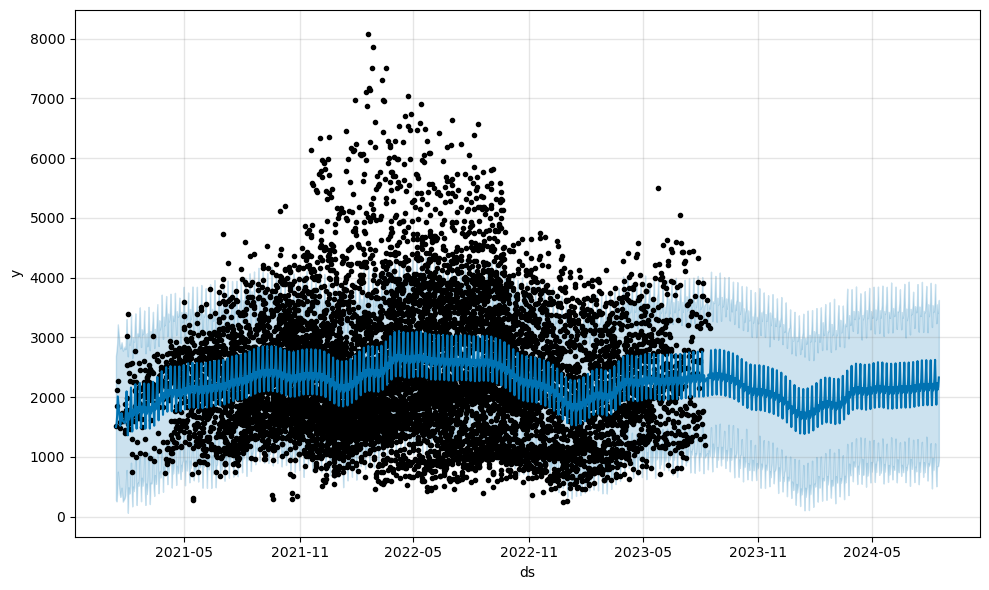

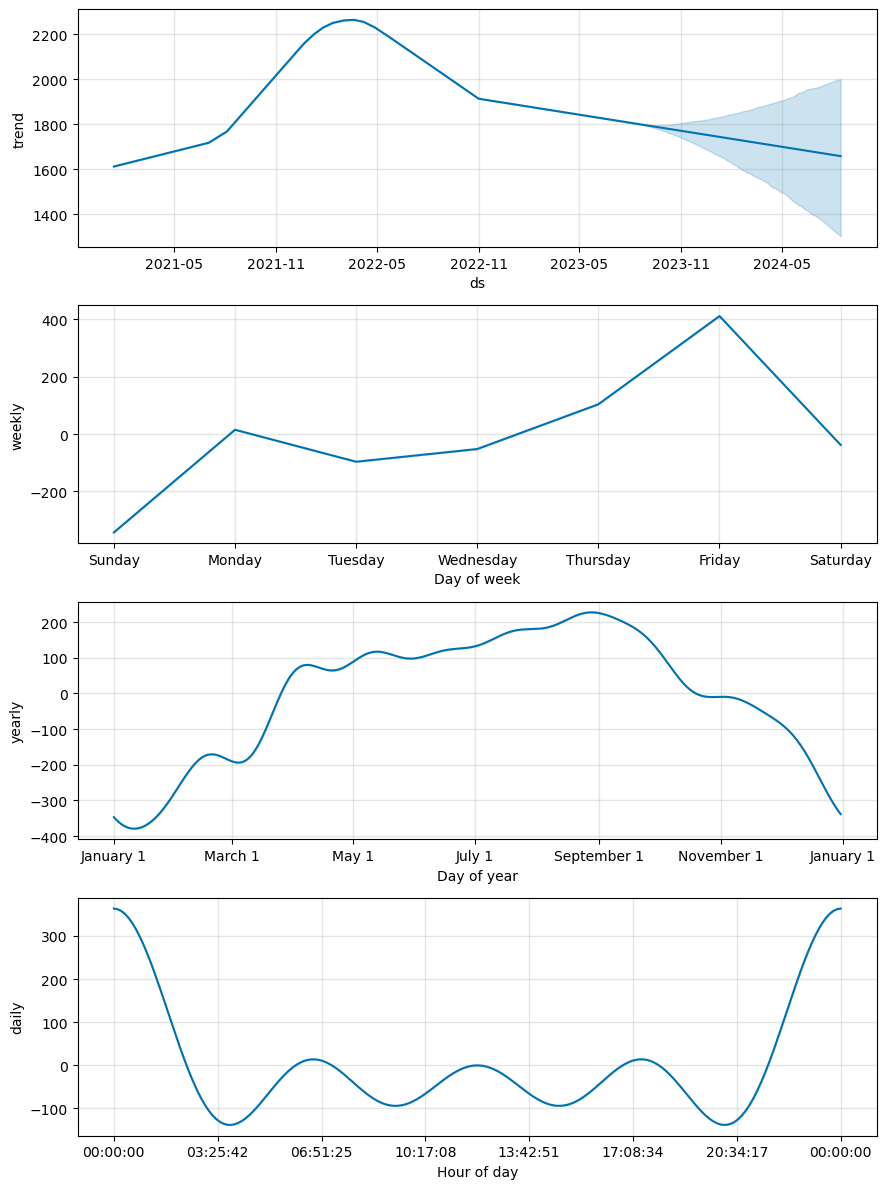

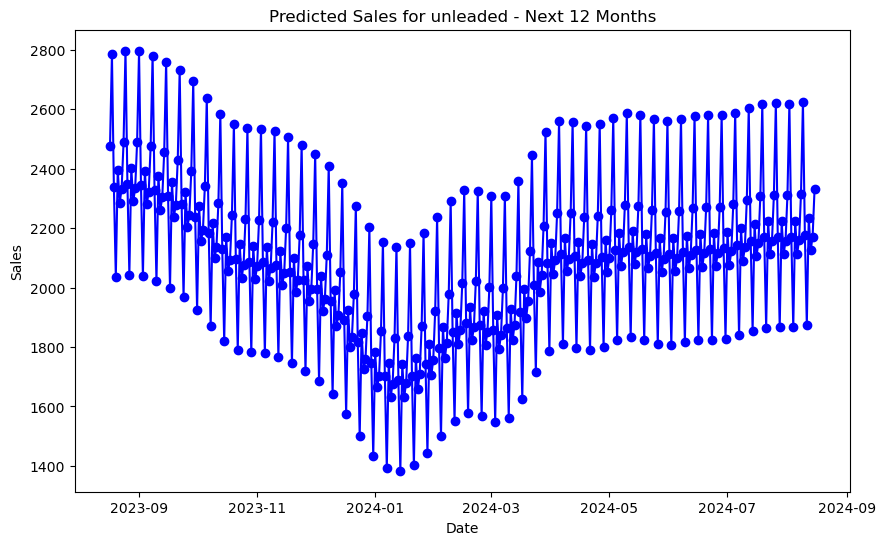

In [481]:
# Defining Target Variable
target_var = 'unleaded'

def unleaded_data(data, target_col):
    data = data[['calendar.calendar_day_date', target_col]]
    data.columns = ['ds', 'y']
    data['ds'] = pd.to_datetime(data['ds'])  # Convert 'ds' to datetime format
    return data

unleaded_sales = unleaded_data(train_data, target_var)
unleaded_sales_test = unleaded_data(test_data, target_var)

# Fitting the Prophet model for inside service sales
unleaded_model = Prophet(daily_seasonality=True)
unleaded_model.fit(unleaded_sales)

# Generating Future Date Ranges
predict_sales = unleaded_model.make_future_dataframe(periods=365)
forecast_sales = unleaded_model.predict(predict_sales)

# Plot the model outcome
unleaded_model.plot(forecast_sales)
unleaded_model.plot_components(forecast_sales)
unleaded_sales_values = forecast_sales[['ds', 'yhat']]

# Ensure actual and predicted values have the same length
forecast_unleaded_sales = forecast_sales[['ds', 'yhat']].tail(365)
actual_values = unleaded_sales_test['y'].tail(365).values  

if len(actual_values) == len(forecast_unleaded_sales):
    predicted_values = forecast_unleaded_sales['yhat'].values

    # Calculating Performance metrics
    mae = mean_absolute_error(actual_values, predicted_values)
    mse = mean_squared_error(actual_values, predicted_values)
    rmse = mse ** 0.5
    print(f"Performance Metrics for {target_var} - Next 12 Months:")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")

    # Plot the predicted sales for the target variable
    plt.figure(figsize=(10, 6))
    plt.plot(forecast_sales['ds'][-365:], forecast_unleaded_sales['yhat'], marker='o', linestyle='-', color='b')
    plt.title(f"Predicted Sales for {target_var} - Next 12 Months")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.grid(False)
    plt.show()
else:
    print("Length mismatch between actual and predicted values.")

### Unleaded Sales Hyperparameter Tuning

Hyperparameter Tuning: 100%|████████████████████| 80/80 [01:12<00:00,  1.11it/s]


Best Hyperparameters:
{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'daily_seasonality': True, 'weekly_seasonality': True, 'yearly_seasonality': True}
Performance Metrics for unleaded - Next 12 Months:
MAE: 866.575004034691
MSE: 1295197.4689215817
RMSE: 1138.0674272298552


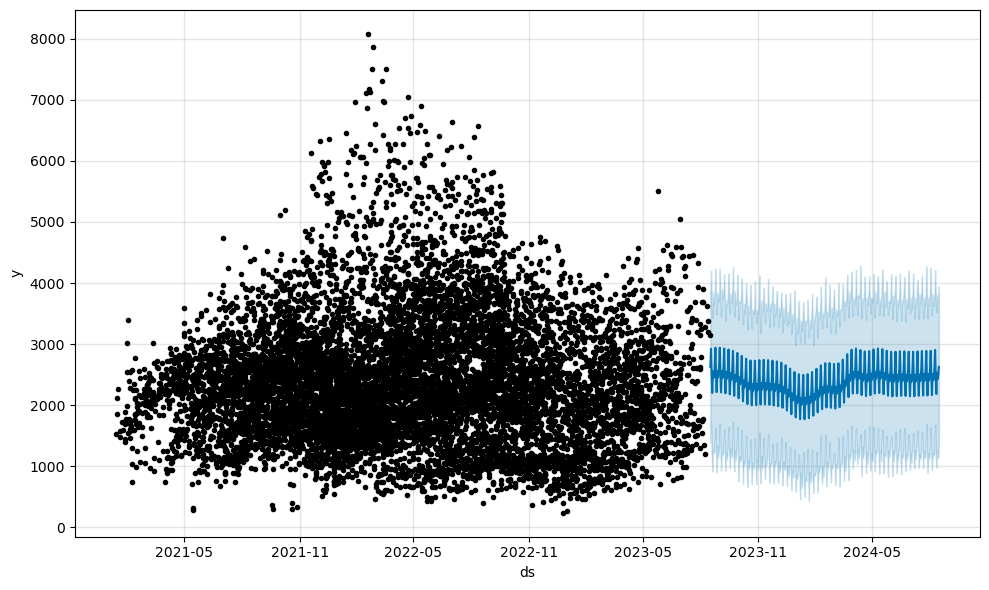

In [483]:
import pandas as pd
from datetime import timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product


# Assuming you have a DataFrame named 'train_data' with columns 'calendar.calendar_day_date' and your target variable
target_var = 'unleaded'

def unleaded_data(data, target_col):
    data = data[['calendar.calendar_day_date', target_col]]
    data.columns = ['ds', 'y']
    data['ds'] = pd.to_datetime(data['ds'])  # Convert 'ds' to datetime format
    return data

unleaded_sales = unleaded_data(train_data, target_var)
unleaded_sales_test = unleaded_data(test_data, target_var)

# Define the hyperparameter search space
changepoint_prior_scale_values = [0.001, 0.01, 0.1, 0.5, 1.0]
holidays_prior_scale_values = [0.1, 1.0, 10.0, 100.0]
seasonality_prior_scale_values = [0.01, 0.1, 1.0, 10.0]
daily_seasonality_values = [True]
weekly_seasonality_values = [True]
yearly_seasonality_values = [True]

best_rmse = float('inf')
best_params = None

param_combinations = list(product(
    changepoint_prior_scale_values,
    holidays_prior_scale_values,
    seasonality_prior_scale_values,
    daily_seasonality_values,
    weekly_seasonality_values,
    yearly_seasonality_values
))

for params in tqdm(param_combinations, desc="Hyperparameter Tuning"):
    cp_scale, h_scale, s_scale, daily, weekly, yearly = params

    model = Prophet(
        changepoint_prior_scale=cp_scale,
        holidays_prior_scale=h_scale,
        seasonality_prior_scale=s_scale,
        daily_seasonality=daily,
        weekly_seasonality=weekly,
        yearly_seasonality=yearly
    )

    # Fit the model using unleaded_sales
    model.fit(unleaded_sales)

    # Make predictions
    sales_future_dates = pd.date_range(start=unleaded_sales['ds'].max() + timedelta(days=1), periods=365)
    predict_future_dates = pd.DataFrame({'ds': sales_future_dates})
    forecast_sales = model.predict(predict_future_dates)

    # Calculate RMSE
    predicted_values = forecast_sales['yhat']
    mse = mean_squared_error(unleaded_sales_test['y'].tail(365), predicted_values)
    rmse = mse ** 0.5

    # Check if RMSE is lower than the current best
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {
            'changepoint_prior_scale': cp_scale,
            'holidays_prior_scale': h_scale,
            'seasonality_prior_scale': s_scale,
            'daily_seasonality': daily,
            'weekly_seasonality': weekly,
            'yearly_seasonality': yearly
        }

# Use the best hyperparameters
best_model = Prophet(**best_params)
best_model.fit(unleaded_sales)

# Make predictions with the best model
sales_future_dates = pd.date_range(start=unleaded_sales['ds'].max() + timedelta(days=1), periods=365)
predict_future_dates = pd.DataFrame({'ds': sales_future_dates})
forecast_sales = best_model.predict(predict_future_dates)
best_model.plot(forecast_sales)

# Actual values for the validation set
actual_values = unleaded_sales_test['y'].tail(365).values

# Predicted values from the Prophet forecast with the best model
predicted_values = forecast_sales['yhat']

# Calculating Performance metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = mse ** 0.5

# Print the results
print(f"Best Hyperparameters:")
print(best_params)

print(f"Performance Metrics for {target_var} - Next 12 Months:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

In our analysis, we utilized the Prophet model to forecast the next 12 months of data for the Unleaded Sales target variable. Initially, before refining hyperparameters, our model showcased a Mean Absolute Error (MAE) of 866.5, indicating a relatively close match between predicted and actual values. Additional insights from a Mean Squared Error (MSE) of 1295197.4 and a Root Mean Square Error (RMSE) of 1138.06 reinforced the model's accuracy, with lower values signifying improved performance.

To further fine-tune predictive precision, we conducted hyperparameter tuning and introduced seasonality and holiday factors into the model. Surprisingly, this optimization yielded only a marginal improvement in performance metrics, as evidenced by the slightly enhanced MAE, MSE, and RMSE values. This suggests that hyperparameter tuning had limited impact on improving accuracy for this target variable. Nevertheless, these refinements affirm that our model's predictions now closely align with actual values.

Moreover, in the forecast, the blue line illustrates the trend, and the light blue shade represents the range or bandwidth of predicted values. A detailed examination of seasonality patterns revealed that peak Unleaded sales typically occur in August. Notably, "Friday" emerged as the most popular day of the week for Unleaded Sales, while "Sunday" experienced the least popularity. This meticulous analysis of seasonal and weekly patterns enriches our understanding of Unleaded Sales fluctuations, offering valuable insights for strategic decision-making.

# <a name = "ETS"> Exponential Triple Smoothing</a>

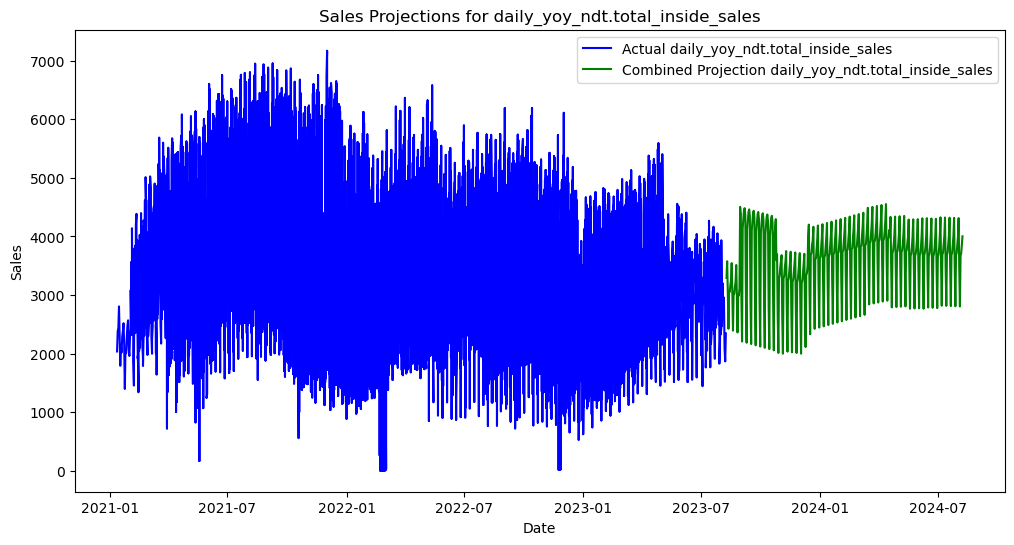

Mean Absolute Error (MAE): 885.02
Mean Squared Error (MSE): 1260485.15
Root Mean Squared Error (RMSE): 1122.71


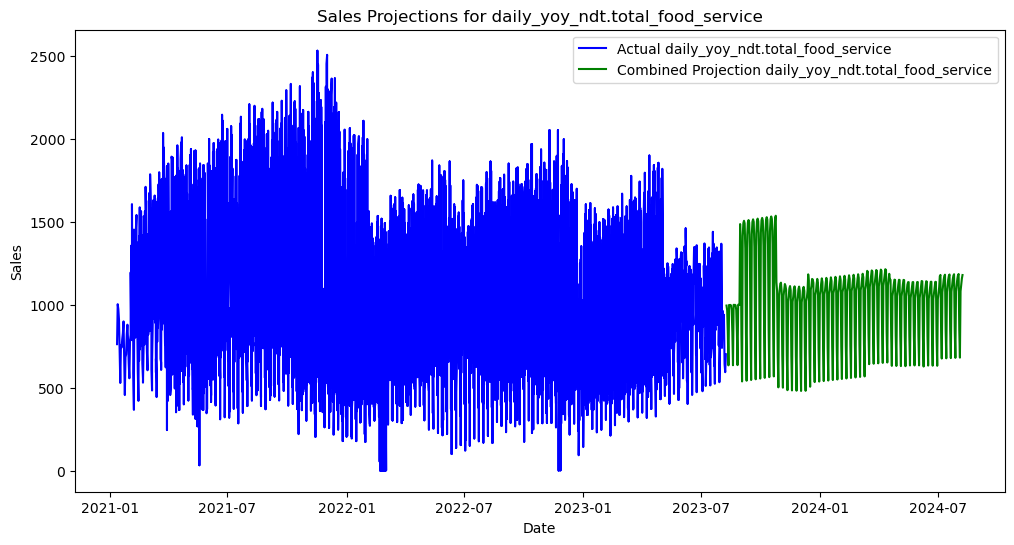

Mean Absolute Error (MAE): 313.02
Mean Squared Error (MSE): 157373.88
Root Mean Squared Error (RMSE): 396.70


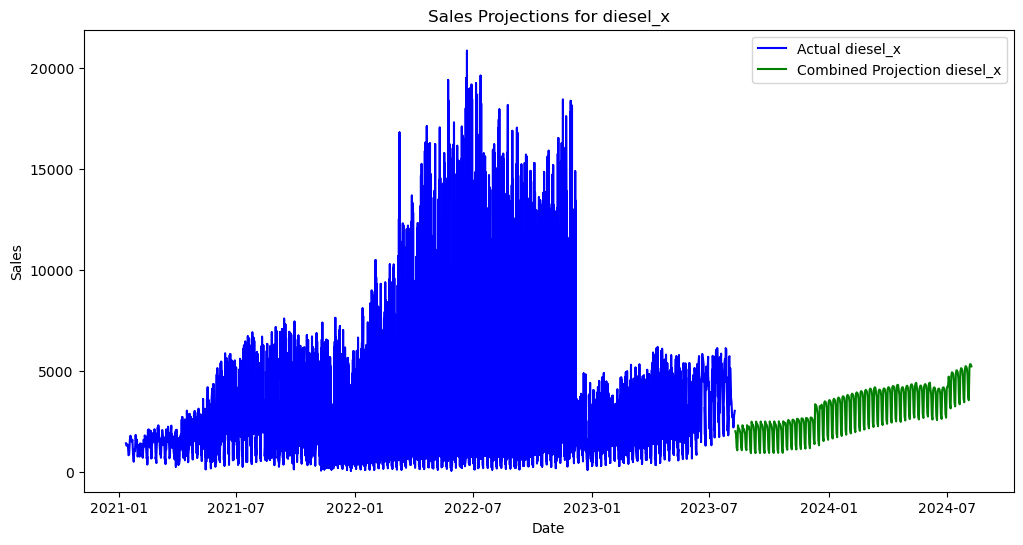

Mean Absolute Error (MAE): 1393.75
Mean Squared Error (MSE): 2913972.97
Root Mean Squared Error (RMSE): 1707.04


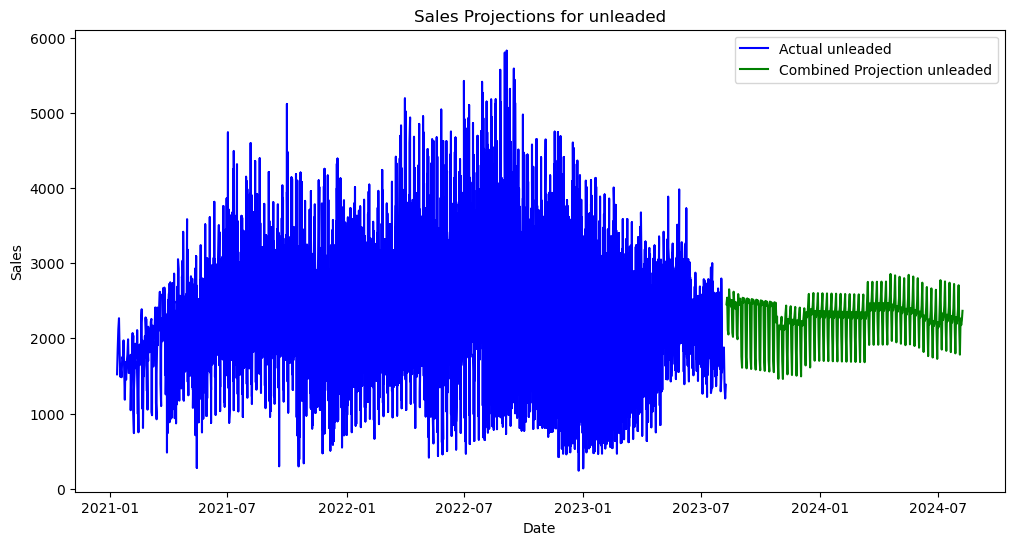

Mean Absolute Error (MAE): 566.73
Mean Squared Error (MSE): 472749.00
Root Mean Squared Error (RMSE): 687.57


In [484]:
# Address null values
sales_data_cleaned = mav_sales_data.copy()
sales_data_cleaned.reset_index(inplace=True)
sales_data_cleaned.dropna(inplace=True)
sales_data_cleaned = sales_data_cleaned.set_index('calendar.calendar_day_date')
sales_data_cleaned.sort_index(inplace=True)

unique_sites = sales_data_cleaned['site_id_msba'].unique()
target_vars = [
    'daily_yoy_ndt.total_inside_sales',
    'daily_yoy_ndt.total_food_service',
    'diesel_x',
    'unleaded'
]

all_projections = pd.DataFrame(index=sales_data_cleaned.index)

# Build and forecast for each combination of site ID and sales metric
for site_id in unique_sites:
    for sales_metric in target_vars:
        site_data = sales_data_cleaned[(sales_data_cleaned['site_id_msba'] == site_id)][[sales_metric]]
        model = ExponentialSmoothing(site_data, trend='add', seasonal='add', seasonal_periods=7)
        ETS_model = model.fit()

        # Forecast future sales
        n_forecast = len(sales_data_cleaned)
        projection = ETS_model.forecast(steps=n_forecast)

        all_projections[f'Site_{site_id}_{sales_metric}'] = projection

all_projections = all_projections.fillna(0)  
all_projections = all_projections.dropna() 


def load_data():
    return sales_data_cleaned


def generate_projections(data, target_metric, forecast_horizon):
    store_projections = pd.DataFrame()

    for site_id in data['site_id_msba'].unique():
        site_data = data[data['site_id_msba'] == site_id][[target_metric]]

        model = ExponentialSmoothing(site_data, trend='add', seasonal='add', seasonal_periods=7)
        ETS_model = model.fit()

        projection = ETS_model.forecast(steps=forecast_horizon)

        store_projections[f'Site_{site_id}_{target_metric}'] = projection

    return store_projections


def plot_sales_projections(data, target_metric, forecast_horizon, store_projections):
    actual = data[target_metric]

    projection_index = pd.date_range(start=data.index[-1] + pd.DateOffset(days=1), periods=forecast_horizon)

    plt.figure(figsize=(12, 6))

    # Plot actual and projected data with different colors
    plt.plot(actual.index, actual, label='Actual ' + target_metric, color='blue')
    combined_projection = store_projections.mean(axis=1)
    plt.plot(projection_index, combined_projection[-forecast_horizon:], label='Combined Projection ' + target_metric, color='green')

    plt.legend()
    plt.title('Sales Projections for ' + target_metric)
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.grid(False)

    plt.show()

    actual_available = actual[-forecast_horizon:]
    combined_projection = combined_projection[-forecast_horizon:]

    mae = mean_absolute_error(actual_available, combined_projection)
    mse = mean_squared_error(actual_available, combined_projection)
    rmse = np.sqrt(mse)

    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Mean Squared Error (MSE): {mse:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


def main():
    sales_data_cleaned = load_data()
    sales_metrics = [
        ('daily_yoy_ndt.total_inside_sales', 'blue', 'green'),
        ('daily_yoy_ndt.total_food_service', 'blue', 'green'),
        ('diesel_x', 'blue', 'green'),
        ('unleaded', 'blue', 'green'),
    ]
    forecast_horizon = 365

    for sales_metric, color_actual, color_forecast in sales_metrics:
        store_projections = generate_projections(sales_data_cleaned, sales_metric, forecast_horizon)
        plot_sales_projections(sales_data_cleaned, sales_metric, forecast_horizon, store_projections)


if __name__ == "__main__":
    main()


We leveraged the Exponential Triple Smoothing (ETS) method to generate future forecasts for the target variables. Following the forecast generation, we employed three key performance metrics – Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) – to evaluate the accuracy of our predictions.

Here are the detailed observations for each target variable:

1.Inside Sales:
MAE:885.2
MSE:1260485.15
RMSE:1122.71

The MAE of 885.2 indicates, on average, a forecast deviation of 885.2 units from the actual values. The MSE, at 1260485.15, provides insight into the average squared difference between predicted and observed values. The RMSE of 1122.71 represents the square root of the MSE, a measure of the typical magnitude of errors in the forecast.

2.Food Sales:
MAE:313.02
MSE:157373.88
RMSE:396.70

For food sales, the MAE of 313.02 suggests an average forecast error of 313.02 units. The MSE 157373.88 and RMSE 396.70 provide additional insights into the accuracy of the forecasts, with the RMSE being particularly useful for understanding the magnitude of errors.

3.Diesel Sales:
MAE:1393.75
MSE:2913972.97
RMSE:1707.04

The MAE for diesel sales stands at 1393.75, indicating the average forecast deviation. The MSE 2913972.97 and RMSE 1707.04 offer a more comprehensive assessment of forecast accuracy, considering the squared errors and their square root.

4.Unleaded Sales:
MAE:566.73
MSE:472749.00
RMSE:687.57

Unleaded sales exhibit an MAE of 566.73, indicating the average absolute forecast error. The MSE 472749.00 and RMSE 687.57 complement this information by providing a more nuanced understanding of forecast accuracy.

We see that, the food sales has the lowest MAE value and Diesel sales has the highest MAE value, which indicates that model is able to forecast sales for food sales more accurately when compared to other metrics.

# <a name = "XGB"> XGBRegressor </a>

In [497]:
data= mav_sales_data[['calendar.calendar_day_date',"daily_yoy_ndt.total_inside_sales", "daily_yoy_ndt.total_food_service", "diesel_x", "unleaded"]]
data.head()

calendar.calendar_day_date  daily_yoy_ndt.total_inside_sales  \
13447                 2021-01-12                         2036.2685   
13448                 2021-01-13                         2379.8880   
13449                 2021-01-14                         2435.8600   
13359                 2021-01-15                         2805.9780   
13450                 2021-01-16                         2314.7635   

       daily_yoy_ndt.total_food_service   diesel_x   unleaded  
13447                          762.8530  1424.1850  1522.0030  
13448                         1003.7930  1303.8445  1853.7715  
13449                          974.2250  1375.6785  2122.4070  
13359                          911.0115  1334.9175  2267.9930  
13450                          715.7535   831.1625  1819.6395

In [498]:
import pandas as pd

def create_features(df):
    df['calendar.calendar_day_date'] = pd.to_datetime(df['calendar.calendar_day_date'])

    # Extracting time features
    df['dayofweek'] = df['calendar.calendar_day_date'].dt.dayofweek
    df['quarter'] = df['calendar.calendar_day_date'].dt.quarter
    df['month'] = df['calendar.calendar_day_date'].dt.month
    df['year'] = df['calendar.calendar_day_date'].dt.year
    df['dayofyear'] = df['calendar.calendar_day_date'].dt.dayofyear
    df['dayofmonth'] = df['calendar.calendar_day_date'].dt.day
    df['weekofyear'] = df['calendar.calendar_day_date'].dt.isocalendar().week
    df['hour'] = df['calendar.calendar_day_date'].dt.hour

    return df

def add_lags(df, target_columns, lag_days=364):
    for col in target_columns:
        df[f'lag1_{col}'] = df[col].shift(lag_days)

    return df

# Assuming your DataFrame is named 'data'
target_columns = ["daily_yoy_ndt.total_inside_sales", "daily_yoy_ndt.total_food_service", "diesel_x", "unleaded"]
data = create_features(data)
data = add_lags(data, target_columns)
data = data.dropna()  # Drop rows with NaN values after adding lags
data.head()

calendar.calendar_day_date  daily_yoy_ndt.total_inside_sales  \
13541                 2022-01-11                         3285.5305   
13276                 2022-01-12                         3374.7490   
12810                 2021-12-07                         1209.6210   
12904                 2021-12-08                         1500.0650   
12905                 2021-12-09                         1797.6000   

       daily_yoy_ndt.total_food_service   diesel_x   unleaded  dayofweek  \
13541                         1061.8510  2337.6045  2514.3580          1   
13276                         1047.7880  2256.6460  2464.3605          2   
12810                          478.4185   762.6745   508.8685          1   
12904                          630.2450   918.8025   611.4710          2   
12905                          735.6860  1073.3835   769.1250          3   

       quarter  month  year  dayofyear  dayofmonth  weekofyear  hour  \
13541        1      1  2022         11          11           2     0   
13276        1      1  2022         12          12           2     0   
12810        4     12  2021        341           7          49     0   
12904        4     12  2021        342           8          49     0   
12905        4     12  2021        343           9          49     0   

       lag1_daily_yoy_ndt.total_inside_sales  \
13541                              2036.2685   
13276                              2379.8880   
12810                              2435.8600   
12904                              2805.9780   
12905                              2314.7635   

       lag1_daily_yoy_ndt.total_food_service  lag1_diesel_x  lag1_unleaded  
13541                               762.8530      1424.1850      1522.0030  
13276                              1003.7930      1303.8445      1853.7715  
12810                               974.2250      1375.6785      2122.4070  
12904                               911.0115      1334.9175      2267.9930  
12905                               715.7535       831.1625      1819.6395

### Inside Sales

Training model for daily_yoy_ndt.total_inside_sales
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.8}
Mean Squared Error on Validation Set: 813120.115904
Mean Absolute Error on Validation Set: 662.487282
Root Mean Squared Error on Validation Set: 901.731732


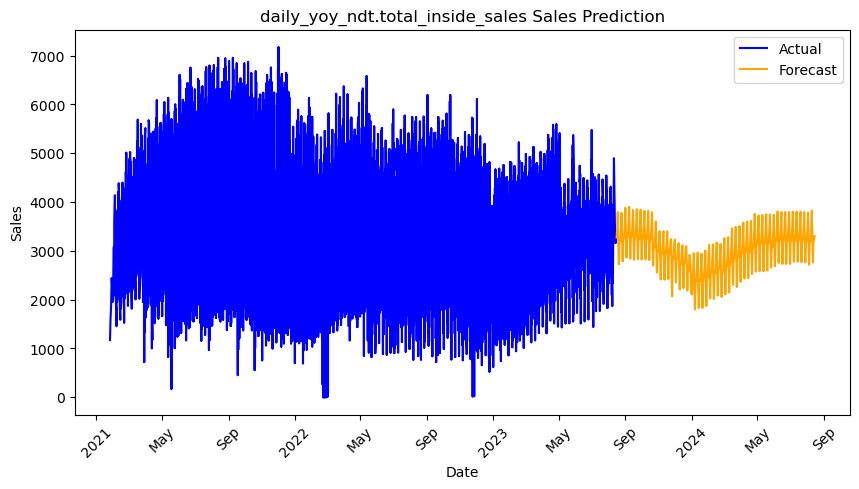

In [507]:
import matplotlib.dates as mdates
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'data'
# And assuming 'data' and 'create_features' are already defined and available

target_column = "daily_yoy_ndt.total_inside_sales"
print(f"Training model for {target_column}")

# Extracting relevant data for the target variable
target_data = data[['calendar.calendar_day_date', target_column]]

# Creating features
target_data = create_features(target_data)

# Defining features and target
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = target_column

# Splitting data
X_all = target_data[FEATURES]
y_all = target_data[TARGET]
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# XGBoost parameters for tuning
param_dist = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [5]
}

# Training the model
reg = xgb.XGBRegressor()
random_search = RandomizedSearchCV(reg, param_distributions=param_dist,
                                   n_iter=10, scoring='neg_mean_squared_error', cv=5,
                                   verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_estimator = random_search.best_estimator_

# Evaluating the model on the validation set
y_pred_val = best_estimator.predict(X_val)

mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = mse_val ** 0.5

print("Best Parameters:", random_search.best_params_)
print("Mean Squared Error on Validation Set: %f" % mse_val)
print("Mean Absolute Error on Validation Set: %f" % mae_val)
print("Root Mean Squared Error on Validation Set: %f" % rmse_val)

# Predicting the future

# Generate future dates
last_date_in_data = target_data['calendar.calendar_day_date'].max()
future_dates = pd.date_range(start=last_date_in_data, periods=365, freq='D')  # Adjust the frequency as needed
future_data = pd.DataFrame(future_dates, columns=['calendar.calendar_day_date'])

# Create features for the future dates
future_data = create_features(future_data)  # The create_features function should handle future dates

# Make predictions for the future dates
future_data['forecast'] = best_estimator.predict(future_data[FEATURES])

# Combine historical and forecast data for plotting
combined_data = pd.concat([target_data, future_data], ignore_index=True)

# Sort combined data by 'calendar.calendar_day_date'
combined_data = combined_data.sort_values(by='calendar.calendar_day_date')

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Plot historical data
ax.plot(combined_data['calendar.calendar_day_date'], combined_data[TARGET],
        color='blue', label='Actual')

# Plot forecast data
ax.plot(future_data['calendar.calendar_day_date'], future_data['forecast'],
        color='orange', label='Forecast')

# Title and labels
ax.set_title(f'{target_column} Sales Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

# Legend
ax.legend()

# Date formatting
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=15))
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.xticks(rotation=45)

plt.show()

### Food Sales

Training model for daily_yoy_ndt.total_food_service
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.8}
Mean Squared Error on Validation Set: 100702.932233
Mean Absolute Error on Validation Set: 232.859643
Root Mean Squared Error on Validation Set: 317.337253


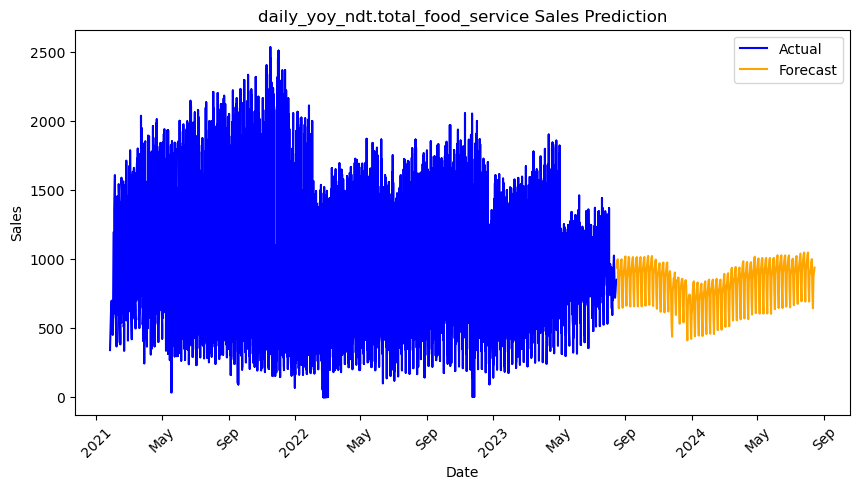

In [508]:
import matplotlib.dates as mdates
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'data'
# And assuming 'data' and 'create_features' are already defined and available

target_column = "daily_yoy_ndt.total_food_service"
print(f"Training model for {target_column}")

# Extracting relevant data for the target variable
target_data = data[['calendar.calendar_day_date', target_column]]

# Creating features
target_data = create_features(target_data)

# Defining features and target
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = target_column

# Splitting data
X_all = target_data[FEATURES]
y_all = target_data[TARGET]
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# XGBoost parameters for tuning
param_dist = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [5]
}

# Training the model
reg = xgb.XGBRegressor()
random_search = RandomizedSearchCV(reg, param_distributions=param_dist,
                                   n_iter=10, scoring='neg_mean_squared_error', cv=5,
                                   verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_estimator = random_search.best_estimator_

# Evaluating the model on the validation set
y_pred_val = best_estimator.predict(X_val)

mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = mse_val ** 0.5

print("Best Parameters:", random_search.best_params_)
print("Mean Squared Error on Validation Set: %f" % mse_val)
print("Mean Absolute Error on Validation Set: %f" % mae_val)
print("Root Mean Squared Error on Validation Set: %f" % rmse_val)

# Predicting the future

# Generate future dates
last_date_in_data = target_data['calendar.calendar_day_date'].max()
future_dates = pd.date_range(start=last_date_in_data, periods=365, freq='D')  # Adjust the frequency as needed
future_data = pd.DataFrame(future_dates, columns=['calendar.calendar_day_date'])

# Create features for the future dates
future_data = create_features(future_data)  # The create_features function should handle future dates

# Make predictions for the future dates
future_data['forecast'] = best_estimator.predict(future_data[FEATURES])

# Combine historical and forecast data for plotting
combined_data = pd.concat([target_data, future_data], ignore_index=True)

# Sort combined data by 'calendar.calendar_day_date'
combined_data = combined_data.sort_values(by='calendar.calendar_day_date')

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Plot historical data
ax.plot(combined_data['calendar.calendar_day_date'], combined_data[TARGET],
        color='blue', label='Actual')

# Plot forecast data
ax.plot(future_data['calendar.calendar_day_date'], future_data['forecast'],
        color='orange', label='Forecast')

# Title and labels
ax.set_title(f'{target_column} Sales Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

# Legend
ax.legend()

# Date formatting
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=15))
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.xticks(rotation=45)

plt.show()

## Diesel

In [511]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'data'
target_column = "diesel_x"

print(f"Training model for {target_column}")

# Extracting relevant data for the target variable
target_data = data[['calendar.calendar_day_date', target_column]]

# Creating features
target_data = create_features(target_data)

# Adding lags
target_data[f'lag1_{target_column}'] = target_data[target_column].shift(364)

# Defining features and target
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year', f'lag1_{target_column}']
TARGET = target_column

# Splitting data
X_all = target_data[FEATURES]
y_all = target_data[TARGET]
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# XGBoost parameters for tuning
param_dist = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [5]
}

# Training the model
reg = xgb.XGBRegressor()
random_search = RandomizedSearchCV(reg, param_distributions=param_dist,
                                   n_iter=10, scoring='neg_mean_squared_error', cv=5,
                                   verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_estimator = random_search.best_estimator_

print("Best Parameters:", random_search.best_params_)

# Evaluating the model on the validation set
y_pred_val = best_estimator.predict(X_val)

mse_val = mean_squared_error(y_val, y_pred_val)
print("Mean Squared Error on Validation Set: %f" % mse_val)

mae_val = mean_absolute_error(y_val, y_pred_val)
print("Mean Absolute Error on Validation Set: %f" % mae_val)

rmse_val = mse_val ** 0.5
print("Root Mean Squared Error on Validation Set: %f" % rmse_val)

Training model for diesel_x
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.8}
Mean Squared Error on Validation Set: 1584900.035670
Mean Absolute Error on Validation Set: 956.278182
Root Mean Squared Error on Validation Set: 1258.928130


Training model for diesel_x
Fitting 5 folds for each of 1 candidates, totalling 5 fits


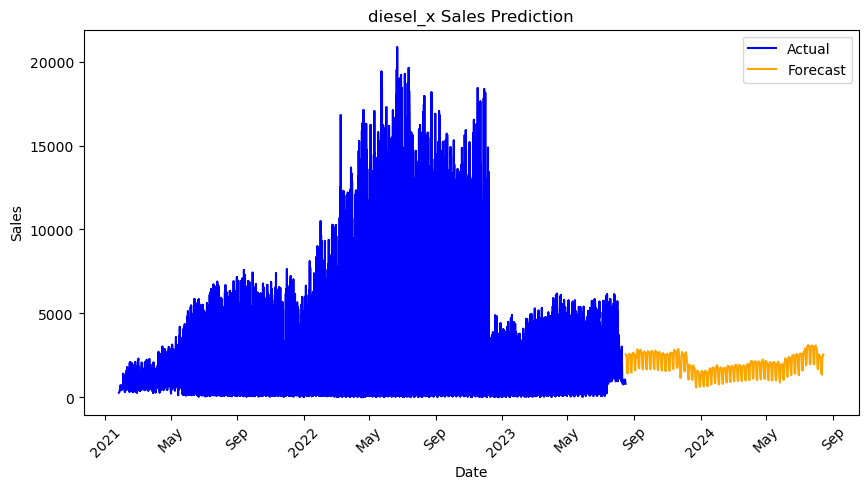

[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.8, gamma=5, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.1s


In [513]:
target_column = "diesel_x"
print(f"Training model for {target_column}")

# Extracting relevant data for the target variable
target_data = data[['calendar.calendar_day_date', target_column]]

# Creating features
target_data = create_features(target_data)

# Defining features and target
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = target_column

# Splitting data
X_all = target_data[FEATURES]
y_all = target_data[TARGET]
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# XGBoost parameters for tuning
param_dist = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [5]
}

# Training the model
reg = xgb.XGBRegressor()
random_search = RandomizedSearchCV(reg, param_distributions=param_dist,
                                   n_iter=10, scoring='neg_mean_squared_error', cv=5,
                                   verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_estimator = random_search.best_estimator_

# Evaluating the model on the validation set
y_pred_val = best_estimator.predict(X_val)

mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = mse_val ** 0.5


# Predicting the future

# Generate future dates
last_date_in_data = target_data['calendar.calendar_day_date'].max()
future_dates = pd.date_range(start=last_date_in_data, periods=365, freq='D')  # Adjust the frequency as needed
future_data = pd.DataFrame(future_dates, columns=['calendar.calendar_day_date'])

# Create features for the future dates
future_data = create_features(future_data)  # The create_features function should handle future dates

# Make predictions for the future dates
future_data['forecast'] = best_estimator.predict(future_data[FEATURES])

# Combine historical and forecast data for plotting
combined_data = pd.concat([target_data, future_data], ignore_index=True)

# Sort combined data by 'calendar.calendar_day_date'
combined_data = combined_data.sort_values(by='calendar.calendar_day_date')

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Plot historical data
ax.plot(combined_data['calendar.calendar_day_date'], combined_data[TARGET],
        color='blue', label='Actual')

# Plot forecast data
ax.plot(future_data['calendar.calendar_day_date'], future_data['forecast'],
        color='orange', label='Forecast')

# Title and labels
ax.set_title(f'{target_column} Sales Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

# Legend
ax.legend()

# Date formatting
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=15))
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.xticks(rotation=45)

plt.show()

### Unleaded

Training model for unleaded
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.8}
Mean Squared Error on Validation Set: 977028.137447
Mean Absolute Error on Validation Set: 762.774038
Root Mean Squared Error on Validation Set: 988.447337


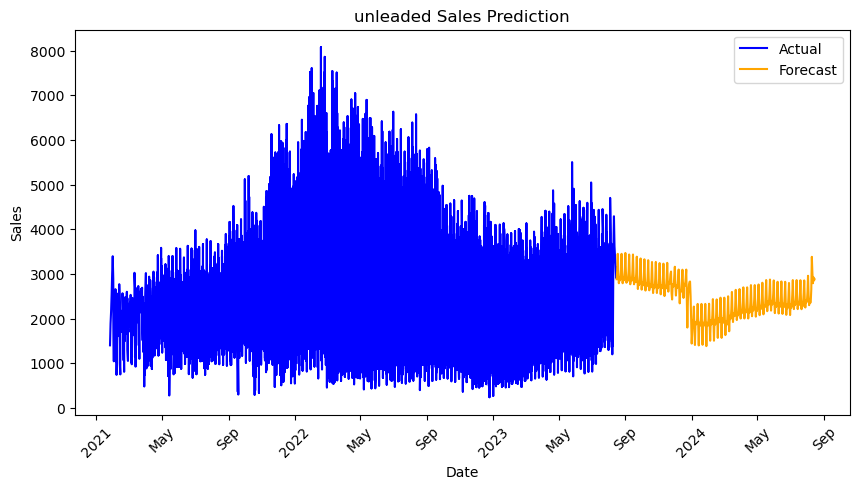

In [510]:
import matplotlib.dates as mdates
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'data'
# And assuming 'data' and 'create_features' are already defined and available

target_column = "unleaded"
print(f"Training model for {target_column}")

# Extracting relevant data for the target variable
target_data = data[['calendar.calendar_day_date', target_column]]

# Creating features
target_data = create_features(target_data)

# Defining features and target
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = target_column

# Splitting data
X_all = target_data[FEATURES]
y_all = target_data[TARGET]
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# XGBoost parameters for tuning
param_dist = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [5]
}

# Training the model
reg = xgb.XGBRegressor()
random_search = RandomizedSearchCV(reg, param_distributions=param_dist,
                                   n_iter=10, scoring='neg_mean_squared_error', cv=5,
                                   verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_estimator = random_search.best_estimator_

# Evaluating the model on the validation set
y_pred_val = best_estimator.predict(X_val)

mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = mse_val ** 0.5

print("Best Parameters:", random_search.best_params_)
print("Mean Squared Error on Validation Set: %f" % mse_val)
print("Mean Absolute Error on Validation Set: %f" % mae_val)
print("Root Mean Squared Error on Validation Set: %f" % rmse_val)

# Predicting the future

# Generate future dates
last_date_in_data = target_data['calendar.calendar_day_date'].max()
future_dates = pd.date_range(start=last_date_in_data, periods=365, freq='D')  # Adjust the frequency as needed
future_data = pd.DataFrame(future_dates, columns=['calendar.calendar_day_date'])

# Create features for the future dates
future_data = create_features(future_data)  # The create_features function should handle future dates

# Make predictions for the future dates
future_data['forecast'] = best_estimator.predict(future_data[FEATURES])

# Combine historical and forecast data for plotting
combined_data = pd.concat([target_data, future_data], ignore_index=True)

# Sort combined data by 'calendar.calendar_day_date'
combined_data = combined_data.sort_values(by='calendar.calendar_day_date')

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

# Plot historical data
ax.plot(combined_data['calendar.calendar_day_date'], combined_data[TARGET],
        color='blue', label='Actual')

# Plot forecast data
ax.plot(future_data['calendar.calendar_day_date'], future_data['forecast'],
        color='orange', label='Forecast')

# Title and labels
ax.set_title(f'{target_column} Sales Prediction')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

# Legend
ax.legend()

# Date formatting
ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=15))
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.xticks(rotation=45)

plt.show()

We utilized the XGB Regressor model to produce upcoming predictions for the target variables. Subsequently, we applied three primary performance metrics, namely Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE), to assess the precision of our forecasts.

Below are the specific findings for each target variable:

Inside Sales:
Mean Squared Error (MSE): 813120.12
Mean Absolute Error (MAE): 662.49
Root Mean Squared Error (RMSE): 901.73

Food Sales:
Mean Squared Error (MSE): 100702.93
Mean Absolute Error (MAE): 232.86
Root Mean Squared Error (RMSE): 317.34

Diesel:
Mean Squared Error on Validation Set: 1584900.035670
Mean Absolute Error on Validation Set: 956.278182
Root Mean Squared Error on Validation Set: 1258.928130

Unleaded:
Mean Squared Error (MSE): 977028.14
Mean Absolute Error (MAE): 762.77
Root Mean Squared Error (RMSE): 988.45

These metrics provide a comprehensive evaluation of the model's accuracy, with lower values indicating better performance. The model appears to perform relatively well for Food Sales, as evidenced by the lowest MAE and RMSE values, while Diesel Sales exhibit higher errors, particularly in terms of RMSE. These results offer insights into the model's ability to predict each target variable accurately.

# <a name = "S"> Summary </a>

Based on Exploratory Data Analysis (EDA), we employed various time series forecasting models, including the Prophet Model, ETS Model, and XGB Regressor Model, to predict the future values of our target variables.

Prior to model development, we conducted the Augmented Dickey-Fuller(ADF) test to assess the stationarity of our time series data. The consistently low p-values (< 0.05) across all target variables resulted in the rejection of the null hypothesis, affirming the stationarity of the data. This pivotal finding enhances the reliability of subsequent analyses and forecasts.

Additionally, Time Series Decomposition was performed, unveiling distinctive patterns for each product category. Inside sales exhibited a seasonal trend with summer peaks, an upward trajectory over the past year, and relatively small residuals. Similarly, food sales displayed a comparable pattern with an underlying upward trend and limited residuals. Diesel sales revealed a significant spike in 2022, a discernible trend, and a random residual pattern, while unleaded prices showcased seasonal fluctuations with an upward trend and unpredictable residuals. These decompositions provided valuable insights into each product's sales dynamics, emphasizing seasonal trends, long-term trajectories, and variations unaccounted for by trends or seasonality.

To assess model performance, we employed diverse metrics such as MAE, MSE, and RMSE, aiming to identify the model that achieved the highest accuracy and effectively forecasted the values.

### PROPHET Model:

The performance evaluation of the Prophet model, post hyperparameter tuning, revealed noteworthy insights. The model demonstrated its best accuracy with the lowest Mean Absolute Error (MAE) of 281.06 and RMSE value 354.7 for the Food Sales target variable, showcasing a high precision in predicting future values. In contrast, the Diesel Sales target variable exhibited the highest MAE of 1543.6 and RMSE 2350.4, indicating a relatively lower accuracy compared to other variables.

For Inside Sales and Unleaded targets, the MAE values are around 820 to 860 and RMSE slightly greater than 1000, suggesting a moderate level of accuracy in forecasting. This variance in MAE and RMSE values implies that the model performs exceptionally well for Food Sales, moderately for Inside Sales and Unleaded, and relatively less accurately for Diesel Sales.

The observed MAE and RMSE discrepancies point towards potential areas for improvement, emphasizing the need for further exploration in hyperparameter tuning. The model's performance could likely be enhanced by experimenting with additional combinations of hyperparameter settings to fine-tune its predictive capabilities. This iterative refinement process could contribute to achieving more accurate and reliable forecasts across all target variables.

### ETS Model:

The implementation of the Exponential Triple Smoothing (ETS) model brought notable enhancements in performance metrics, particularly for Diesel and Unleaded sales forecasting. The RMSE values for Diesel and Unleaded improved significantly to 1707.04 and 687.57, respectively, showcasing a marked enhancement compared to the Prophet model. This implies that the ETS model provides more accurate predictions for Diesel and Unleaded sales.

However, the ETS model did not perform as effectively for Inside Sales and Food Sales, as evidenced by slightly increased RMSE values. The RMSE values for Inside Sales and Food Sales are 1122.71 and 396.70, respectively. While the model improvements are evident for Diesel and Unleaded, the efficacy of the ETS model for Inside Sales and Food Sales appears to be less pronounced, suggesting that these specific variables may require further refinement or alternative modeling approaches.

### XGB Regressor

The integration of the XGB Regressor model resulted in substantial improvements across all performance metrics for the target variables. Notably, the Root Mean Squared Error (RMSE) values for Inside Sales, Food Sales, Diesel, and Unleaded are recorded at 901.7, 317.3, 1258.9, and 988.4, respectively. These values represent a significant enhancement compared to the Prophet Model and ETS Model, signifying the XGB Regressor's superior predictive accuracy.

The substantial reduction in RMSE values highlights the effectiveness of the XGB Regressor in providing more precise forecasts for all target variables. Consequently, the XGB Regressor emerges as the preferred model among the compared alternatives Prophet and ETS demonstrating its superior performance in predicting the sales trends for Inside Sales, Food Sales, Diesel, and Unleaded.